#1.DATA EXPORTATION

1.1 Data exportation - LIGUE 1 DEFENDERS

In [ ]:
import requests
import pandas as pd
import time
import numpy as np # Import numpy for robust percentage calculations

# API key - Replace with your actual API key
api_key = 'ba53d657e0973b0ae6f5a6b0be2f88d1'

# Request headers
headers = {
    'x-apisports-key': api_key
}

# Ligue 1 ID and season
league_id = 61 # Ligue 1 ID
season = 2023
page = 1
all_players = []

print("Starting API data collection for Ligue 1 Defenders (2023/2024 season)...")

# Fetching all player data page by page
while True:
    print(f"Requesting page {page}...")
    params = {
        'league': league_id,
        'season': season,
        'page': page
    }
    response = requests.get('https://v3.football.api-sports.io/players', headers=headers, params=params)
    data = response.json()

    # Check for errors in API response
    if data['errors']:
        print(f"❌ API Error on page {page}: {data['errors']}")
        break
    if not data['response']:
        break # No more players to fetch

    for player_entry in data['response']:
        player_info = player_entry['player']
        stats = player_entry['statistics'][0] # Get the first (and usually only) set of stats for the league/season

        # Extract relevant metrics for defenders (same as midfielders for initial API pull)
        # Using .get() with default values (0 or None) to handle cases where a stat might be missing
        merged_stats = {
            'name': player_info['name'],
            'team': stats['team']['name'],
            'position': stats['games']['position'],
            'minutes': stats['games']['minutes'],

            # Duels (API provides total and won)
            'duels_total': stats.get('duels', {}).get('total', 0),
            'duels_won': stats.get('duels', {}).get('won', 0),

            # Goals scored
            'goals': stats.get('goals', {}).get('total', 0),

            # Shots
            'shots_total': stats.get('shots', {}).get('total', 0),
            'shots_on_target': stats.get('shots', {}).get('on_target', 0),

            # Assists
            'assists': stats.get('goals', {}).get('assists', 0),

            # Dribbles
            'dribbles_attempts': stats.get('dribbles', {}).get('attempts', 0),
            'dribbles_success': stats.get('dribbles', {}).get('success', 0),

            # Touches
            'touches_total': stats.get('touches', {}).get('total', 0),

            # Key passes
            'passes_key': stats.get('passes', {}).get('key', 0),

            # Passes (API provides total and accuracy)
            'passes_total': stats.get('passes', {}).get('total', 0),
            'passes_accuracy': stats.get('passes', {}).get('accuracy', 0),

            # Tackles and Interceptions (API provides total for each)
            'tackles': stats.get('tackles', {}).get('total', 0),
            'interceptions': stats.get('tackles', {}).get('interceptions', 0),
        }
        all_players.append(merged_stats)
    page += 1
    time.sleep(1) # Pause for 1 second to respect API rate limits

# Convert the collected data to a Pandas DataFrame
df = pd.DataFrame(all_players)

# Filter for 'Defender' position and players with at least 540 minutes played.
# The 540 minutes threshold ensures we have a sufficient sample size for per-90 metrics.
# 'Defender' is the common position string in API-Sports for defenders.
defenders_df = df[(df['position'] == 'Defender') & (df['minutes'] >= 540)].copy()

# Calculate derived metrics using numpy.where for robust division by zero handling
# Shots on target percentage
defenders_df['shots_on_target_perc'] = np.where(
    defenders_df['shots_total'].fillna(0) != 0,
    (defenders_df['shots_on_target'].fillna(0) / defenders_df['shots_total'].fillna(0)) * 100,
    0.0
)

# Dribble success percentage
defenders_df['dribbles_success_perc'] = np.where(
    defenders_df['dribbles_attempts'].fillna(0) != 0,
    (defenders_df['dribbles_success'].fillna(0) / defenders_df['dribbles_attempts'].fillna(0)) * 100,
    0.0
)

# Save the filtered and processed DataFrame to a CSV file
output_filename = "ligue1_defenders_2023_24_api_stats.csv"
defenders_df.to_csv(output_filename, index=False)
print(f"\n✅ Ligue 1 Defenders API stats (filtered for >=540 mins) saved to: {output_filename}")

# Display the first few rows of the resulting DataFrame and its shape
print("\nFirst 5 rows of the exported Ligue 1 Defenders API stats:")
print(defenders_df.head().to_string())
print(f"\nShape of the exported Ligue 1 Defenders API stats: {defenders_df.shape}")


Starting API data collection for Ligue 1 Defenders (2023/2024 season)...
Requesting page 1...
Requesting page 2...
Requesting page 3...
Requesting page 4...
Requesting page 5...
Requesting page 6...
Requesting page 7...
Requesting page 8...
Requesting page 9...
Requesting page 10...
Requesting page 11...
Requesting page 12...
Requesting page 13...
Requesting page 14...
Requesting page 15...
Requesting page 16...
Requesting page 17...
Requesting page 18...
Requesting page 19...
Requesting page 20...
Requesting page 21...
Requesting page 22...
Requesting page 23...
Requesting page 24...
Requesting page 25...
Requesting page 26...
Requesting page 27...
Requesting page 28...
Requesting page 29...
Requesting page 30...
Requesting page 31...
Requesting page 32...
Requesting page 33...
Requesting page 34...
Requesting page 35...
Requesting page 36...
Requesting page 37...
Requesting page 38...
Requesting page 39...
Requesting page 40...
Requesting page 41...
Requesting page 42...
Requesting p

In [ ]:
import pandas as pd

# Load the API-exported defenders stats.
# This file is expected to already contain only defenders with >= 540 minutes.
try:
    df_api_defenders = pd.read_csv("ligue1_defenders_2023_24_api_stats.csv")
    print("✅ Ligue 1 Defenders API stats loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_api_stats.csv' not found.")
    print("Please ensure this file has been generated by the 'Ligue 1 Defenders API Data Export' step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Filter for 'Defender' position and players with 540 minutes or more.
# Although the input file should already be filtered, this step re-confirms it.
defenders_filtered = df_api_defenders[
    (df_api_defenders['position'] == 'Defender') &
    (df_api_defenders['minutes'] >= 540)
].copy()

# Showing how many players were found
print(f"\n✅ Ligue 1 Defenders with 540 minutes or more found (re-confirmed): {len(defenders_filtered)}")

# Printing the available columns in the filtered dataset
print("\nAvailable columns for filtered Ligue 1 defenders:")
print(defenders_filtered.columns.tolist())

# Save the filtered dataset to a new CSV file
output_filename = "ligue1_defenders_2023_24_filtered.csv"
defenders_filtered.to_csv(output_filename, index=False)
print(f"\n✅ Filtered Ligue 1 defenders dataset saved as: {output_filename}")

# Display the first few rows of the filtered dataset
print("\nFirst 5 rows of the filtered Ligue 1 defenders dataset:")
print(defenders_filtered.head().to_string())


✅ Ligue 1 Defenders API stats loaded successfully.

✅ Ligue 1 Defenders with 540 minutes or more found (re-confirmed): 130

Available columns for filtered Ligue 1 defenders:
['name', 'team', 'position', 'minutes', 'duels_total', 'duels_won', 'goals', 'shots_total', 'shots_on_target', 'assists', 'dribbles_attempts', 'dribbles_success', 'touches_total', 'passes_key', 'passes_total', 'passes_accuracy', 'tackles', 'interceptions', 'shots_on_target_perc', 'dribbles_success_perc']

✅ Filtered Ligue 1 defenders dataset saved as: ligue1_defenders_2023_24_filtered.csv

First 5 rows of the filtered Ligue 1 defenders dataset:
                name           team  position  minutes  duels_total  duels_won  goals  shots_total  shots_on_target  assists  dribbles_attempts  dribbles_success  touches_total  passes_key  passes_total  passes_accuracy  tackles  interceptions  shots_on_target_perc  dribbles_success_perc
0         V. Le Goff        Lorient  Defender    545.0         27.0       16.0    1.0   

I am enhancing the Ligue 1 2023/24 defenders dataset by adding accurate passing accuracy values and defensive actions from FBref as they were missing from the previous dataset(API).

The goal is to improve clustering quality by including an essential tactical metric , passes completed divided by passes attempted.

To make this work, I must:

    Load the 3 datasets (the API data and FBref passing data and defensive actions)

    Ensure player and team names are aligned

    Merge them carefully

    Update our dataset with the accurate passes_accuracy values

    Save the cleaned and enriched version for clustering

In [ ]:
%pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.6 MB/s eta 0:00:00


The following code block is responsible for merging the primary API data for Ligue 1 defenders with additional detailed passing and defensive statistics from FBref. It performs crucial steps like standardizing player and team names (including extensive manual mappings for consistency), filtering out aggregate data, and updating key metrics like passes_accuracy with more reliable FBref data. The goal is to create a comprehensive and clean dataset for subsequent analysis.

In [ ]:
import pandas as pd
import unidecode

try:
    import unidecode
except ImportError:
    print("Installing 'unidecode' library...")
    # Use pip to install the library
    import subprocess
    subprocess.check_call(['pip', 'install', 'unidecode'])
    import unidecode
    print(" 'unidecode' installed successfully.")


# Step 1: Load the three datasets for defenders
# Ensure these CSV files are in the same directory as your script
try:
    # Updated API data filename for defenders
    api_df = pd.read_csv("ligue1_defenders_2023_24_api_stats.csv")
    passing_df = pd.read_csv("Ligue1_passing.csv", encoding='ISO-8859-1', sep=None, engine='python')
    defensive_df = pd.read_csv("Ligue1_defensive_actions.csv", encoding='ISO-8859-1', sep=None, engine='python')
    print("✅ All datasets loaded successfully for defenders.")
except FileNotFoundError as e:
    print(f"❌ Error loading file: {e}. Make sure all CSV files are in the correct directory and generated.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# --- Pre-clean HTML entities in player names ---
# This step converts HTML entity for apostrophe to a standard apostrophe
# to ensure consistent string matching before further cleaning.
api_df['name'] = api_df['name'].str.replace('&apos;', "'", regex=False)
passing_df['Player'] = passing_df['Player'].str.replace('&apos;', "'", regex=False)
defensive_df['Player'] = defensive_df['Player'].str.replace('&apos;', "'", regex=False)
print("✅ HTML apostrophe entities converted to standard apostrophes in player names.")
# --- END Pre-clean HTML entities ---

# Step 2: Clean and standardize player and team names for merging
# This ensures consistent matching across different data sources (API, FBref)
# unidecode handles special characters (e.g., accents), .lower() for case insensitivity, .strip() for whitespace
api_df['name_clean'] = api_df['name'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())
api_df['team_clean'] = api_df['team'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())

passing_df['name_clean'] = passing_df['Player'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())
passing_df['team_clean'] = passing_df['Squad'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())

defensive_df['name_clean'] = defensive_df['Player'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())
defensive_df['team_clean'] = defensive_df['Squad'].apply(lambda x: unidecode.unidecode(str(x)).lower().strip())

# --- Team Name Standardization ---
# This dictionary maps common variations of Ligue 1 team names to a consistent format.
# This is crucial for successful merging across different data sources.
team_name_standardization = {
    'paris saint-germain': 'paris sg',
    'olympique marseille': 'marseille',
    'olympique lyonnais': 'lyon',
    'lille osc': 'lille',
    'rc lens': 'lens',
    'stade rennais': 'rennes',
    'ogc nice': 'nice',
    'as monaco': 'monaco',
    'stade de reims': 'reims',
    'montpellier hsc': 'montpellier',
    'fc lorient': 'lorient',
    'strasbourg': 'strasbourg', # Some sources might use 'rc strasbourg'
    'clermont foot 63': 'clermont foot',
    'le havre ac': 'le havre',
    'fc metz': 'metz',
    'brest': 'brest', # Some sources might use 'stade brestois 29'
    'nantes': 'nantes', # Some sources might use 'fc nantes'
    'toulouse': 'toulouse', # Some sources might use 'toulouse fc'
    'auxerre': 'auxerre', # If relevant for 23/24, ensure consistency
    'angers': 'angers', # If relevant for 23/24, ensure consistency
    'ajaccio': 'ajaccio', # If relevant for 23/24, ensure consistency
    'paris s-g': 'paris sg', # Added for FBref consistency
    'stade brestois 29': 'brest', # Added for FBref consistency
    'paris saint germain': 'paris sg', # Added for API consistency (no hyphen)
}

# Apply standardization to all relevant 'team_clean' columns
api_df['team_clean'] = api_df['team_clean'].replace(team_name_standardization)
passing_df['team_clean'] = passing_df['team_clean'].replace(team_name_standardization)
defensive_df['team_clean'] = defensive_df['team_clean'].replace(team_name_standardization)

# --- Filter out 'squad' from FBref team_clean ---
# 'squad' often represents aggregate data and should not be treated as a team for individual players.
passing_df = passing_df[passing_df['team_clean'] != 'squad'].copy()
defensive_df = defensive_df[defensive_df['team_clean'] != 'squad'].copy()
print("✅ 'squad' entries filtered from FBref team names.")
# --- END NEW ---

# --- Manual Player Name Standardization for Defenders ---
# This dictionary maps specific problematic API player names (after initial cleaning)
# to their corresponding FBref cleaned names to ensure successful merges.
# Populate this dictionary based on the 'Detailed rows without matching FBref data'
# from the diagnostic output below.
# Example: 'api_player_name_cleaned': 'fbref_player_name_cleaned'
player_name_manual_mapping = {
    'v. le goff': 'vincent le goff',
    'm. zeffane': 'mehdi zeffane',
    'r. pierre-gabriel': 'ronael pierre-gabriel',
    'a. pelmard': 'andy pelmard',
    'b. omeragic': 'becir omeragic',
    'y. abdelhamid': 'yunis abdelhamid',
    'k. kouyate': 'boubakar kouyate',
    'f. sacko': 'falaye sacko',
    'm. sagnan': 'modibo sagnan',
    'c. jullien': 'christopher jullien',
    'i. sylla': 'issiaga sylla',
    'e. tchato': 'enzo tchato',
    'l. mincarelli davin': 'lucas mincarelli', # Special case, API has 'Davin' FBref doesn't
    'm. haidara': 'massadio haidara',
    'n. pallois': 'nicolas pallois',
    'j. okumu': 'joseph okumu',
    'c. mbemba': 'chancel mbemba',
    'j. lotomba': 'jordan lotomba',
    'm. caufriez': 'maximiliano caufriez',
    'g. gudmundsson': 'gabriel gudmundsson',
    'l. perrin': 'lucas perrin',
    'n. tagliafico': 'nicolas tagliafico',
    'd. caleta-car': 'duje caleta-car', # Added after search
    's. kumbedi': 'sael kumbedi',
    'c. wooh': 'christopher wooh',
    'l. brassier': 'lilian brassier',
    'w. omari': 'warmed omari',
    'a. seidu': 'alidu seidu',
    'd. machado': 'deiver machado',
    'r. aguilar': 'ruben aguilar',
    'j. gradit': 'jonathan gradit',
    'r. nicolaisen': 'rasmus nicolaisen',
    'w. kamanzi': 'warren kamanzi',
    'l. balerdi': 'leonardo balerdi',
    'u. garcia': 'ulisses garcia',
    's. gigot': 'samuel gigot',
    'a. murillo': 'michael amir murillo',
    'f. medina': 'facundo medina',
    't. de smet': 'thibault de smet',
    'b. meite': 'bamo meite',
    'q. merlin': 'quentin merlin',
    'b. chardonnet': 'brendan chardonnet',
    'k. lala': 'kenny lala',
    'b. locko': 'bradley locko',
    'g. doue': 'guela doue',
    'i. doukoure': 'ismael doukoure',
    's. sow': 'saidou sow',
    'a. sylla': 'abakar sylla',
    'a. hakimi': 'achraf hakimi',
    'l. hernandez': 'lucas hernandez',
    'm. skriniar': 'milan skriniar', # Added after search
    'n. mukiele': 'nordi mukiele',
    'beraldo': 'lucas beraldo', # Special case, only first name in API
    'j. clauss': 'jonathan clauss',
    'm. bard': 'melvin bard',
    'j. castelletto': 'jean-charles castelletto',
    'j. duverne': 'jean-kevin duverne',
    'k. amian': 'kelvin amian',
    't. kehrer': 'thilo kehrer',
    'caio henrique': 'caio henrique oliveira silva', # Full name in FBref
    'w. singo': 'wilfried singo',
    'm. salisu': 'mohammed salisu',
    'k. ouattara': 'kassoum ouattara',
    'c. mawissa elebi': 'christian mawissa', # API has 'Elebi'
    'k. van den kerkhof': 'kevin van den kerkhof', # Added after search
    'i. traore': 'ismael traore',
    'm. colin': 'maxime colin',
    'm. udol': 'matthieu udol',
    'k. kouao': 'koffi kouao',
    'b. mendy': 'benjamin mendy',
    'j. laporte': 'julien laporte',
    'g. kalulu': 'gedeon kalulu',
    'm. talbi': 'montassar talbi',
    'd. yongwa': 'darlin yongwa',
    'f. mendy': 'formose mendy',
    's. toure': 'souleymane toure',
    'n. adjei': 'nathaniel adjei',
    'p. katseris': 'panos katseris',
    'b. diakite': 'bafode diakite',
    'l. nego': 'loic nego',
    't. delaine': 'thomas delaine',
    'g. lloris': 'gautier lloris',
    'e. youte': 'etienne youte kinkoue', # API has 'Youté', FBref has 'Youte Kinkoue'
    's. diomande': 'sinaly diomande',
    'a. sangante': 'arouna sangante',
    'm. senaya': 'marvin senaya',
    'g. maripan': 'guillermo maripan',
    'f. guilbert': 'frederic guilbert',
    'f. ogier': 'florent ogier',
    'n. cozza': 'nicolas cozza',
    's. hefti': 'silvan hefti',
    'c. matsima': 'chrislain matsima',
    'l. assignon': 'lorenz assignon',
    'a. theate': 'arthur theate',
    'j. belocian': 'jeanuel belocian',
    'g. suazo': 'gabriel suazo',
    'e. comert': 'eray comert',
    'm. diarra': 'moussa diarra',
    'e. agbadou': 'emmanuel agbadou',
    'a. truffert': 'adrien truffert',
    'm. esteve': 'maxime esteve',
    'j. todibo': 'jean-clair todibo',
    'k. danso': 'kevin danso',
    'j. o\'brien': 'jake o\'brien',
    'l. yoro': 'leny yoro',
    'a. khusanov': 'abdukodir khusanov',
    'c. operi': 'christopher operi',
    't. foket': 'thomas foket',
    'c. herelle': 'christophe herelle',
    'g. nyamsi': 'gerzino nyamsi',
    'i. jakobs': 'ismail jakobs',
    'y. salmier': 'yoann salmier',
    'c. konate': 'cheick konate',
    'd. lovren': 'dejan lovren',
    'm. desler': 'mikkel desler',
    'n. zeze': 'nathan zeze',
    'l. zogbe': 'luck zogbe',
    'y. zague': 'yoram zague',
    'c. wooh': 'christopher wooh',
    'm. wieteska': 'mateusz wieteska',
    's. umtiti': 'samuel umtiti',
    'j. todibo': 'jean-clair todibo',
    'a. theate': 'arthur theate',
    'd. sylla': 'dembo sylla',
    'e. sobol': 'eduard sobol',
    'm. skriniar': 'milan skriniar',
    'c. h. oliveira silva': 'caio henrique oliveira silva', # More specific for Caio Henrique
    'm. sarr': 'mamadou sarr',
    't. santos': 'tiago santos',
    's. sane': 'sadibou sane',
    'm. sakho': 'mamadou sakho',
    't. sainte-luce': 'theo sainte-luce',
    'a. ribeiro': 'alexsandro ribeiro',
    'a. pelon': 'aurelien pelon',
    'm. nagida': 'mahamadou nagida',
    'l. mouyokolo': 'loris mouyokolo',
    'e. mongo': 'enzo mongo',
    'b. meupiyou': 'bastien meupiyou',
    'a. mendy': 'antoine mendy',
    'n. mendes': 'nuno mendes',
    'b. meling': 'birger meling',
    'c. mata': 'clinton mata',
    'marquinhos': 'marquinhos', # Already full name
    'r. lodi': 'renan lodi',
    'j. le cardinal': 'julien le cardinal',
    'l. kurzawa': 'layvin kurzawa',
    't. koudou': 'therence koudou',
    'a. kone': 'abdoul kone',
    'k. keben biakolo': 'kevin keben biakolo',
    'j. jacquet': 'jeremy jacquet',
    'ismaily': 'ismaily', # Already full name
    'h. henrique': 'henrique', # Assuming this is the API form for Henrique
    'j. hadjam': 'jaouen hadjam',
    'f. cande': 'fali cande',
    'j. chavez': 'jhoanner chavez',
    'f. centonze': 'fabien centonze',
    'a. cartillier': 'antonin cartillier',
    'dante': 'dante', # Already full name
    'l. costa': 'logan costa',
    's. baseya': 'steven baseya',
    'y. atal': 'youcef atal',
    'j. amavi': 'jordan amavi',
    's. akieme': 'sergio akieme',
    'd. pereira': 'danilo pereira',
    'j. wilson-esbrand': 'josh wilson-esbrand',
    'r. perraud': 'romain perraud',
    'a. dari': 'achraf dari',
    'm. coco': 'marcus coco',
    'adryelson': 'adryelson',
    # Additional mappings for specific cases or common patterns
    'caio henrique': 'caio henrique oliveira silva',
    'vanderson': 'vanderson',
    'danilo pereira': 'danilo pereira',
    'henrique': 'henrique',
    'ismaily': 'ismaily',
    'marquinhos': 'marquinhos',
    'dante': 'dante',
    'adryelson': 'adryelson',
}

# Apply the manual player name mapping to the API DataFrame's cleaned names
api_df['name_clean'] = api_df['name_clean'].replace(player_name_manual_mapping)
print("✅ Player and team names cleaned and standardized for defenders, including manual player and team name standardization.")
# --- END Manual Player Name Standardization ---

# --- Diagnostic: Sample of Cleaned Names and Teams before Merge ---
print("\n--- Diagnostic: Sample of Cleaned Names and Teams before Merge ---")
print("\nAPI DataFrame (name, name_clean, team, team_clean) AFTER all cleaning and mapping:") # NEW: Clarified
print(api_df[['name', 'name_clean', 'team', 'team_clean']].head().to_string())

print("\nPassing DataFrame (Player, name_clean, Squad, team_clean):")
print(passing_df[['Player', 'name_clean', 'Squad', 'team_clean']].head().to_string())

print("\nDefensive DataFrame (Player, name_clean, Squad, team_clean):")
print(defensive_df[['Player', 'name_clean', 'Squad', 'team_clean']].head().to_string())
print("--- End Diagnostic ---")

# --- Diagnostic: Unique cleaned names and teams ---
print("\n--- Diagnostic: Unique Cleaned Names and Teams in each DataFrame ---")
print("\nUnique API Player Cleaned Names (sample first 10):")
print(api_df['name_clean'].unique()[:10].tolist())
print("\nUnique API Team Cleaned Names (all):")
print(api_df['team_clean'].unique().tolist())

print("\nUnique Passing FBref Player Cleaned Names (sample first 10):")
print(passing_df['name_clean'].unique()[:10].tolist())
print("\nUnique Passing FBref Team Cleaned Names (all):")
print(passing_df['team_clean'].unique().tolist())

print("\nUnique Defensive FBref Player Cleaned Names (sample first 10):")
print(defensive_df['name_clean'].unique()[:10].tolist())
print("\nUnique Defensive FBref Team Cleaned Names (all):")
print(defensive_df['team_clean'].unique().tolist())
print("--- End Unique Names Diagnostic ---")

# --- NEW Diagnostic: Check for duplicates in API DataFrame before merge ---
print("\n--- Diagnostic: Checking for duplicates in API DataFrame (name_clean, team_clean) ---")
api_duplicates = api_df[api_df.duplicated(subset=['name_clean', 'team_clean'], keep=False)]
if not api_duplicates.empty:
    print("⚠️ Duplicate (name_clean, team_clean) found in API DataFrame:")
    print(api_duplicates[['name', 'team', 'name_clean', 'team_clean']].sort_values(by=['name_clean', 'team_clean']).to_string())
    print(f"Total duplicate entries in API DataFrame: {len(api_duplicates)}")
else:
    print("✅ No duplicate (name_clean, team_clean) found in API DataFrame.")
print("--- End Duplicate Check Diagnostic ---")

# This section performs the crucial data merging steps. It combines player statistics
# from the primary API source with additional detailed passing and defensive metrics
# from FBref. Robust name and team standardization, including manual mappings,
# are applied to maximize successful matches between the datasets.
# The process ensures that all API players are retained (left merge) and enriched
# with FBref data where available, handling missing values by prioritizing FBref
# data and falling back to API data when no FBref match is found.

# Step 3: Merge API data with FBref Passing Data
# 'how='left'' ensures all players from api_df are kept.
# suffixes are used to distinguish columns with the same name from different sources.
merged_df = pd.merge(api_df, passing_df, on=['name_clean', 'team_clean'], how='left', suffixes=('', '_fbref_pass'))
print(f"✅ Merged with FBref Passing Data. Total rows: {len(merged_df)}")

# --- Diagnostic: Check missing values before updating passes_accuracy ---
print("\n--- Diagnostic: Missing values before updating 'passes_accuracy' ---")
print(f"Missing 'passes_accuracy' (from API) before FBref fill: {merged_df['passes_accuracy'].isnull().sum()}")
print(f"Missing 'Cmp%' (from FBref) after merge: {merged_df['Cmp%'].isnull().sum()}")
# --- END Diagnostic ---

# Step 4: Update 'passes_accuracy' with FBref values where available
# This is crucial for replacing the API's less accurate values with FBref's.
# .fillna(merged_df['passes_accuracy']) ensures that if FBref data is NaN (no match),
# the original API value is retained.
merged_df['passes_accuracy'] = merged_df['Cmp%'].fillna(merged_df['passes_accuracy'])
print("✅ 'passes_accuracy' updated with FBref values.")

# --- Diagnostic: Check missing values after updating passes_accuracy ---
print("\n--- Diagnostic: Missing values after updating 'passes_accuracy' ---")
print(f"Missing 'passes_accuracy' after FBref fill: {merged_df['passes_accuracy'].isnull().sum()}")
# --- END Diagnostic ---

# Step 5: Merge with FBref Defensive Actions
# Again, 'how='left'' to keep all players from the previous merge.
# Suffixes are used for potential overlapping column names.
merged_final = pd.merge(merged_df, defensive_df, on=['name_clean', 'team_clean'], how='left', suffixes=('', '_fbref_def'))
print(f"✅ Merged with FBref Defensive Actions. Total rows: {len(merged_final)}")

# --- NEW: Specific Diagnostic for 'Achraf Hakimi' ---
print("\n--- NEW DIAGNOSTIC: Checking 'Achraf Hakimi' in merged_final ---")
achraf_hakimi_row = merged_final[
    (merged_final['name_clean'] == 'achraf hakimi') &
    (merged_final['team_clean'] == 'paris sg')
]
if not achraf_hakimi_row.empty:
    print("Found 'Achraf Hakimi' (Paris SG) in merged_final DataFrame:")
    print(achraf_hakimi_row[['name', 'team', 'name_clean', 'team_clean', 'Cmp%', 'TklW', 'passes_accuracy']].to_string())
else:
    print("Achraf Hakimi (Paris SG) NOT found in merged_final DataFrame by name_clean and team_clean.")
print("--- END NEW DIAGNOSTIC ---")


# --- REFINED UNMATCHED PLAYER CALCULATION (MOVED HERE) ---
# Identify players from API that still have NaN in FBref-derived columns *after* the merge.
# This ensures we are checking for true unmatched status after fillna.
# We check 'Cmp%' (the original FBref column) to see if it was ever populated.
# Note: 'Cmp%' is dropped later, so we must calculate this before dropping.
unmatched_passing_rows = merged_final[merged_final['Cmp%'].isna()]
unmatched_defensive_rows = merged_final[merged_final['TklW'].isna()]

if not unmatched_passing_rows.empty:
    print(f"\n⚠️ Detailed rows without matching FBref Passing data (after merge attempt):")
    print(unmatched_passing_rows[['name', 'team', 'name_clean', 'team_clean', 'Cmp%', 'passes_accuracy']].to_string())

if not unmatched_defensive_rows.empty:
    print(f"\n⚠️ Detailed rows without matching FBref Defensive data (after merge attempt):")
    print(unmatched_defensive_rows[['name', 'team', 'name_clean', 'team_clean', 'TklW']].to_string())

# Get the exact counts for the response
num_unmatched_passing = len(unmatched_passing_rows.drop_duplicates(subset=['name_clean', 'team_clean']))
num_unmatched_defensive = len(unmatched_defensive_rows.drop_duplicates(subset=['name_clean', 'team_clean']))

print(f"\nTotal unique players without matching FBref Passing data: {num_unmatched_passing}")
print(f"Total unique players without matching FBref Defensive data: {num_unmatched_defensive}")
# --- END REFINED UNMATCHED PLAYER CALCULATION ---


# Step 6: Clean up redundant columns after merging and updating
# Drop the specific FBref columns that were used for updating or are redundant.
columns_to_drop = [
    'Player_fbref_pass', 'Squad_fbref_pass', 'Cmp%', # From passing_df
    'Player_fbref_def', 'Squad_fbref_def', # From defensive_df
]

# Filter out columns that don't exist in the DataFrame to prevent errors
columns_to_drop_existing = [col for col in columns_to_drop if col in merged_final.columns]
merged_final.drop(columns=columns_to_drop_existing, inplace=True)
print("✅ Redundant FBref columns dropped.")


# Step 7: Save the cleaned and enriched merged dataset
# Updated output filename for defenders
merged_final.to_csv("ligue1_defenders_2023_24_combined.csv", index=False)
print("✅ Merged and cleaned dataset saved as: ligue1_defenders_2023_24_combined.csv")

# Display a sample of the final DataFrame to verify
print("\nSample of the final combined DataFrame:")
print(merged_final.head().to_string()) # Use .to_string() for full display in console

# --- NEW DETAILED DIAGNOSTIC FOR UNMATCHED PLAYERS ---
print("\n--- Detailed Diagnostic for a Sample of Unmatched Players ---")
sample_size = 10 # Limit the sample size for readability

# Use the *refined* unmatched lists for this diagnostic
# Get unique name_clean from the unmatched rows to sample from
unmatched_player_names_sample = unmatched_passing_rows['name_clean'].unique()[:sample_size]

if len(unmatched_player_names_sample) > 0:
    print(f"\nAnalyzing a sample of {len(unmatched_player_names_sample)} unique unmatched API players:")
    for api_player_name in unmatched_player_names_sample:
        # Find all API rows for this player
        api_player_rows = api_df[api_df['name_clean'] == api_player_name]

        for idx, row in api_player_rows.iterrows():
            api_player_team = row['team_clean']
            original_api_name = row['name']
            original_api_team = row['team']

            print(f"\nAPI Player: '{original_api_name}' (Cleaned: '{api_player_name}') from '{original_api_team}' (Cleaned: '{api_player_team}')")

            # Check if the player's name and team exists in FBref Passing data
            fbref_passing_match = passing_df[
                (passing_df['name_clean'] == api_player_name) &
                (passing_df['team_clean'] == api_player_team)
            ]
            if not fbref_passing_match.empty:
                print(f"  - Found '{api_player_name}' from '{api_player_team}' in FBref Passing data. This entry should have matched.")
                print(f"    FBref Passing Data for this entry:\n{fbref_passing_match[['Player', 'Squad', 'name_clean', 'team_clean', 'Cmp%']].to_string()}")
            else:
                print(f"  - '{api_player_name}' from '{api_player_team}' NOT found in FBref Passing data by name and team.")
                # Check if name exists with different team
                fbref_passing_name_only_matches = passing_df[passing_df['name_clean'] == api_player_name]
                if not fbref_passing_name_only_matches.empty:
                    print(f"    However, '{api_player_name}' found in FBref Passing data with different teams: {fbref_passing_name_only_matches['team_clean'].unique().tolist()}")
                else:
                    print(f"    '{api_player_name}' NOT found in FBref Passing data by name at all.")


            # Check if the player's name and team exists in FBref Defensive data
            fbref_defensive_match = defensive_df[
                (defensive_df['name_clean'] == api_player_name) &
                (defensive_df['team_clean'] == api_player_team)
            ]
            if not fbref_defensive_match.empty:
                print(f"  - Found '{api_player_name}' from '{api_player_team}' in FBref Defensive data. This entry should have matched.")
                print(f"    FBref Defensive Data for this entry:\n{fbref_defensive_match[['Player', 'Squad', 'name_clean', 'team_clean', 'TklW']].to_string()}")
            else:
                print(f"  - '{api_player_name}' from '{api_player_team}' NOT found in FBref Defensive data by name and team.")
                # Check if name exists with different team
                fbref_defensive_name_only_matches = defensive_df[defensive_df['name_clean'] == api_player_name]
                if not fbref_defensive_name_only_matches.empty:
                    print(f"    However, '{api_player_name}' found in FBref Defensive data with different teams: {fbref_defensive_name_only_matches['team_clean'].unique().tolist()}")
                else:
                    print(f"    '{api_player_name}' NOT found in FBref Defensive data by name at all.")
else:
    print("No unique API players found in the unmatched list for further diagnostic.")

print("\n--- End Detailed Diagnostic ---")


✅ All datasets loaded successfully for defenders.
✅ HTML apostrophe entities converted to standard apostrophes in player names.
✅ 'squad' entries filtered from FBref team names.
✅ Player and team names cleaned and standardized for defenders, including manual player and team name standardization.

--- Diagnostic: Sample of Cleaned Names and Teams before Merge ---

API DataFrame (name, name_clean, team, team_clean) AFTER all cleaning and mapping:
                name             name_clean           team     team_clean
0         V. Le Goff        vincent le goff        Lorient        lorient
1         M. Zeffane          mehdi zeffane  Clermont Foot  clermont foot
2  R. Pierre-Gabriel  ronael pierre-gabriel         Nantes         nantes
3         A. Pelmard           andy pelmard  Clermont Foot  clermont foot
4        B. Omeragić         becir omeragic    Montpellier    montpellier

Passing DataFrame (Player, name_clean, Squad, team_clean):
              Player         name_clean      Sq

I am inspecting the missing values to see which of them I do not need.

In [ ]:
import pandas as pd

# Load the combined dataset for Ligue 1 defenders

try:
    df_combined = pd.read_csv("ligue1_defenders_2023_24_combined.csv")
    print("✅ Combined Ligue 1 defenders dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_combined.csv' not found. Please ensure the file exists.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()


# Display columns and shape of the dataset
print("\nColumns in the combined Ligue 1 defenders dataset:")
print(df_combined.columns.tolist())
print("\nShape of the combined Ligue 1 defenders dataset:", df_combined.shape)

# Display the first few rows
print("\nFirst 5 rows of the combined Ligue 1 defenders dataset:")
print(df_combined.head().to_string())


# Check for missing values in each column
missing_values = df_combined.isnull().sum()
missing_percentages = (missing_values / len(df_combined)) * 100

missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentages
})

# Display columns with missing values, sorted by the number of missing values
print("\nMissing values summary for Ligue 1 defenders (columns with missing values only):")
print(missing_summary[missing_summary['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False).to_string())

✅ Combined Ligue 1 defenders dataset loaded successfully.

Columns in the combined Ligue 1 defenders dataset:
['name', 'team', 'position', 'minutes', 'duels_total', 'duels_won', 'goals', 'shots_total', 'shots_on_target', 'assists', 'dribbles_attempts', 'dribbles_success', 'touches_total', 'passes_key', 'passes_total', 'passes_accuracy', 'tackles', 'interceptions', 'shots_on_target_perc', 'dribbles_success_perc', 'name_clean', 'team_clean', 'Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s', 'Cmp', 'Att', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'xAG', 'xA', 'A-xAG', 'KP', '1-???', 'PPA', 'CrsPA', 'PrgP', 'Matches', 'Rk_fbref_def', 'Nation_fbref_def', 'Pos_fbref_def', 'Age_fbref_def', 'Born_fbref_def', '90s_fbref_def', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl.1', 'Att_fbref_def', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Matches_fbref_def']

Shape of the combine

I am dropping the columns that I do not need.

In [ ]:
import pandas as pd

# === Load the combined Ligue 1 defenders dataset ===
try:
    df_combined = pd.read_csv("ligue1_defenders_2023_24_combined.csv")
    print("✅ Combined Ligue 1 defenders dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_combined.csv' not found. Please ensure the file exists.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# === Filter players with >= 540 minutes played ===
initial_player_count = len(df_combined)
df_combined = df_combined[df_combined['minutes'] >= 540].copy()
print(f"✅ Filtered for players with >= 540 minutes. Reduced from {initial_player_count} to {len(df_combined)} players.")

# === Drop columns with high missing values or low relevance ===
columns_to_drop_high_missing = [
    'passes_key', 'shots', 'assists',
    'Pos', 'Att', 'TotDist', 'PrgDist',
    'xAG', 'xA', 'A-xAG', 'KP', '1-???', 'PPA', 'CrsPA', 'PrgP',
    'Matches', 'Rk', 'Unnamed: 0', 'Born',
    'Pos_fbref_pass', 'Pos_fbref_def',
    'Att_fbref_pass', 'Att_fbref_def',
    'Matches_fbref_pass', 'Matches_fbref_def',
    'Rk_fbref_pass', 'Rk_fbref_def',
    'Age', 'Squad'
    # Optional: drop Player / Nation if not used later for clustering
]

df_filtered_high_missing_dropped = df_combined.drop(columns=columns_to_drop_high_missing, errors='ignore')
print(f"✅ Columns with high missing values dropped. New shape: {df_filtered_high_missing_dropped.shape}")

# === Drop rows that still contain any remaining missing values ===
remaining_missing_after_drop = df_filtered_high_missing_dropped.isnull().sum()
columns_with_remaining_missing_after_drop = remaining_missing_after_drop[remaining_missing_after_drop > 0].index.tolist()
print(f"✅ Columns still containing missing values: {columns_with_remaining_missing_after_drop}")

df_cleaned_for_clustering = df_filtered_high_missing_dropped.dropna(subset=columns_with_remaining_missing_after_drop).copy()

# === Final dataset preview ===
print(f"\nOriginal number of players in combined dataset (before 540 min filter): {initial_player_count}")
print(f"Number of players remaining after filtering and cleaning: {len(df_cleaned_for_clustering)}")

if not df_cleaned_for_clustering.empty:
    print("\nFirst 5 rows of cleaned dataset:")
    print(df_cleaned_for_clustering.head().to_string())
else:
    print("\n❌ No players remaining after cleaning.")

print("\n✅ Columns retained for clustering:")
print(df_cleaned_for_clustering.columns.tolist())

# === Save cleaned dataset ===
df_cleaned_for_clustering.to_csv("ligue1_defenders_2023_24_cleaned_for_clustering.csv", index=False)
print("✅ Cleaned dataset saved as: ligue1_defenders_2023_24_cleaned_for_clustering.csv")


✅ Combined Ligue 1 defenders dataset loaded successfully.
✅ Filtered for players with >= 540 minutes. Reduced from 130 to 130 players.
✅ Columns with high missing values dropped. New shape: (130, 53)
✅ Columns still containing missing values: ['duels_total', 'duels_won', 'shots_total', 'dribbles_attempts', 'dribbles_success', 'passes_total', 'tackles', 'interceptions', 'Player', 'Nation', '90s', 'Cmp', 'Cmp.1', 'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'Ast', 'Nation_fbref_def', 'Age_fbref_def', 'Born_fbref_def', '90s_fbref_def', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl.1', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err']

Original number of players in combined dataset (before 540 min filter): 130
Number of players remaining after filtering and cleaning: 122

First 5 rows of cleaned dataset:
                name           team  position  minutes  duels_total  duels_won  goals  shots_total  shots_on_target  dribbles_att

The following code cleans the combined defenders dataset by systematically dropping columns with high missing values and then rows with any remaining missing values, preparing it for machine learning tasks like clustering.

In [ ]:
import pandas as pd

# Load the combined Ligue 1 defenders dataset
try:
    df_combined = pd.read_csv("ligue1_defenders_2023_24_combined.csv")
    print("✅ Combined Ligue 1 defenders dataset loaded successfully.")

    # Drop columns with high missing values or deemed non-essential for clustering
    columns_to_drop_high_missing = [
        'passes_key', 'shots', 'assists', 'Pos', 'Att', 'TotDist', 'PrgDist', 'xAG', 'xA',
        'A-xAG', 'KP', '1-???', 'PPA', 'CrsPA', 'PrgP', 'Matches', 'Rk', 'Unnamed: 0',
        'Born', 'Pos_fbref_pass', 'Pos_fbref_def', 'Att_fbref_pass', 'Att_fbref_def',
        'Matches_fbref_pass', 'Matches_fbref_def', 'Rk_fbref_pass', 'Rk_fbref_def',
        'Age', 'Squad'
    ]

    df_filtered_high_missing_dropped = df_combined.drop(columns=columns_to_drop_high_missing, errors='ignore')

except FileNotFoundError:
    print("❌ Please ensure 'ligue1_defenders_2023_24_combined.csv' exists and rerun the merge steps.")
    raise
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    raise

# Calculate missing values in the remaining columns
remaining_missing_after_drop = df_filtered_high_missing_dropped.isnull().sum()

# Identify columns that still contain missing values
columns_with_remaining_missing_after_drop = remaining_missing_after_drop[remaining_missing_after_drop > 0].index.tolist()

# Drop rows with missing values in those columns
df_cleaned_for_clustering = df_filtered_high_missing_dropped.dropna(subset=columns_with_remaining_missing_after_drop).copy()

# Final summary
print(f"\nOriginal number of players in combined dataset: {len(df_combined)}")
print(f"Number of players remaining after dropping high-missing columns and cleaning: {len(df_cleaned_for_clustering)}")

if not df_cleaned_for_clustering.empty:
    print("\nFirst 5 rows of the cleaned dataset for clustering:")
    print(df_cleaned_for_clustering.head().to_string())
else:
    print("\n❌ No players remaining after cleaning.")

print("\n✅ Columns retained in the cleaned dataset:")
print(df_cleaned_for_clustering.columns.tolist())


✅ Combined Ligue 1 defenders dataset loaded successfully.

Original number of players in combined dataset: 130
Number of players remaining after dropping high-missing columns and cleaning: 122

First 5 rows of the cleaned dataset for clustering:
                name           team  position  minutes  duels_total  duels_won  goals  shots_total  shots_on_target  dribbles_attempts  dribbles_success  touches_total  passes_total  passes_accuracy  tackles  interceptions  shots_on_target_perc  dribbles_success_perc             name_clean     team_clean                 Player  Nation   90s     Cmp  Cmp.1  Att.1  Cmp%.1  Cmp.2  Att.2  Cmp%.2  Cmp.3  Att.3  Cmp%.3  Ast Nation_fbref_def  Age_fbref_def  Born_fbref_def  90s_fbref_def   Tkl  TklW  Def 3rd  Mid 3rd  Att 3rd  Tkl.1  Tkl%  Lost  Blocks    Sh  Pass   Int  Tkl+Int   Clr  Err
0         V. Le Goff        Lorient  Defender    545.0         27.0       16.0    1.0          4.0                0                4.0               4.0             

In [ ]:
# Save the cleaned dataset for clustering
df_cleaned_for_clustering.to_csv("ligue1_defenders_2023_24_cleaned_for_clustering.csv", index=False)

print("✅ Cleaned defender dataset saved as: ligue1_defenders_2023_24_cleaned_for_clustering.csv")


✅ Cleaned defender dataset saved as: ligue1_defenders_2023_24_cleaned_for_clustering.csv


I will keep only the most relevant metrics for defenders.

In [ ]:
import pandas as pd

# Load cleaned Ligue 1 defender dataset
try:
    df_defenders = pd.read_csv("ligue1_defenders_2023_24_cleaned_for_clustering.csv")
    print("✅ Cleaned Ligue 1 defender dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: File not found. Please ensure the cleaned dataset exists.")
    exit()

# Per-90 normalization
metrics_for_p90 = [
    'duels_total', 'duels_won', 'interceptions', 'tackles', 'passes_total',
    'goals', 'Cmp', 'Cmp.1', 'Att.1', 'Cmp.2', 'Att.2', 'Cmp.3', 'Att.3',
    'Ast', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd',
    'Tkl.1', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err'
]

for metric in metrics_for_p90:
    if metric in df_defenders.columns:
        df_defenders[f'{metric}_p90'] = df_defenders.apply(
            lambda row: (row[metric] / row['minutes']) * 90 if row['minutes'] > 0 else 0,
            axis=1
        )

print("✅ Per-90 metrics calculated.")

# Unified column rename mapping
rename_mapping = {
    # API columns
    'passes_accuracy': 'passes_total_accuracy_api',
    'goals': 'goals_total',
    'duels_total': 'duels_total_api',
    'duels_won': 'duels_won_api',
    'interceptions': 'interceptions_api',
    'tackles': 'tackles_api',
    'passes_total': 'passes_total_api',

    # FBref columns
    'Player': 'player_name_fbref',
    'Nation': 'nation_fbref',
    '90s': '90s_played_fbref',
    'Cmp': 'passes_completed_total_fbref',
    'Att': 'passes_attempted_total_fbref',
    'Cmp.1': 'passes_short_cmp_fbref',
    'Att.1': 'passes_short_att_fbref',
    'Cmp%.1': 'passes_short_acc_fbref',
    'Cmp.2': 'passes_medium_cmp_fbref',
    'Att.2': 'passes_medium_att_fbref',
    'Cmp%.2': 'passes_medium_acc_fbref',
    'Cmp.3': 'passes_long_cmp_fbref',
    'Att.3': 'passes_long_att_fbref',
    'Cmp%.3': 'passes_long_acc_fbref',
    'Ast': 'assists_fbref_total',
    'Tkl': 'tackles_total_fbref',
    'TklW': 'tackles_won_total_fbref',
    'Def 3rd': 'tackles_def_3rd_total_fbref',
    'Mid 3rd': 'tackles_mid_3rd_total_fbref',
    'Att 3rd': 'tackles_att_3rd_total_fbref',
    'Tkl.1': 'dribblers_tackled_total_fbref',
    'Tkl%': 'dribblers_tackled_success_perc_fbref',
    'Lost': 'dribbled_past_total_fbref',
    'Blocks': 'blocks_total_fbref',
    'Sh': 'shots_blocked_total_fbref',
    'Pass': 'passes_blocked_total_fbref',
    'Int': 'interceptions_total_fbref',
    'Tkl+Int': 'tackles_interceptions_total_fbref',
    'Clr': 'clearances_total_fbref',
    'Err': 'errors_total_fbref',

    # Per-90 columns
    'duels_total_p90': 'duels_total_p90',
    'duels_won_p90': 'duels_won_p90',
    'interceptions_p90': 'interceptions_p90',
    'tackles_p90': 'tackles_p90',
    'passes_total_p90': 'passes_total_p90',
    'goals_p90': 'goals_p90',
    'Cmp_p90': 'passes_completed_p90_fbref',
    'Cmp.1_p90': 'passes_short_cmp_p90_fbref',
    'Att.1_p90': 'passes_short_att_p90_fbref',
    'Cmp.2_p90': 'passes_medium_cmp_p90_fbref',
    'Att.2_p90': 'passes_medium_att_p90_fbref',
    'Cmp.3_p90': 'passes_long_cmp_p90_fbref',
    'Att.3_p90': 'passes_long_att_p90_fbref',
    'Ast_p90': 'assists_p90_fbref',
    'Tkl_p90': 'tackles_p90_fbref',
    'TklW_p90': 'tackles_won_p90_fbref',
    'Def 3rd_p90': 'tackles_def_3rd_p90_fbref',
    'Mid 3rd_p90': 'tackles_mid_3rd_p90_fbref',
    'Att 3rd_p90': 'tackles_att_3rd_p90_fbref',
    'Tkl.1_p90': 'dribblers_tackled_p90_fbref',
    'Lost_p90': 'dribbled_past_p90_fbref',
    'Blocks_p90': 'blocks_p90_fbref',
    'Sh_p90': 'shots_blocked_p90_fbref',
    'Pass_p90': 'passes_blocked_p90_fbref',
    'Int_p90': 'interceptions_p90_fbref',
    'Tkl+Int_p90': 'tackles_interceptions_p90_fbref',
    'Clr_p90': 'clearances_p90_fbref',
    'Err_p90': 'errors_p90_fbref'
}

df_renamed = df_defenders.rename(columns=rename_mapping)
print("✅ Columns renamed using La Liga mapping.")

# Preview and save
print("\n🔎 Preview of fully standardized Ligue 1 defender data:")
print(df_renamed.head().to_string())

df_renamed.to_csv("ligue1_defenders_2023_24_preprocessed.csv", index=False)
print("\n✅ Preprocessed dataset saved as: ligue1_defenders_2023_24_preprocessed.csv")


✅ Cleaned Ligue 1 defender dataset loaded successfully.
✅ Per-90 metrics calculated.
✅ Columns renamed using La Liga mapping.

🔎 Preview of fully standardized Ligue 1 defender data:
                name           team  position  minutes  duels_total_api  duels_won_api  goals_total  shots_total  shots_on_target  dribbles_attempts  dribbles_success  touches_total  passes_total_api  passes_total_accuracy_api  tackles_api  interceptions_api  shots_on_target_perc  dribbles_success_perc             name_clean     team_clean      player_name_fbref nation_fbref  90s_played_fbref  passes_completed_total_fbref  passes_short_cmp_fbref  passes_short_att_fbref  passes_short_acc_fbref  passes_medium_cmp_fbref  passes_medium_att_fbref  passes_medium_acc_fbref  passes_long_cmp_fbref  passes_long_att_fbref  passes_long_acc_fbref  assists_fbref_total Nation_fbref_def  Age_fbref_def  Born_fbref_def  90s_fbref_def  tackles_total_fbref  tackles_won_total_fbref  tackles_def_3rd_total_fbref  tackles_mid_3rd_

#2. EDA (EXPLORATORY DATA ANALYSIS)

In [ ]:
import pandas as pd

try:
    df_defenders_renamed = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")

    avg_minutes = df_defenders_renamed['minutes'].mean()
    avg_duels_total_p90 = df_defenders_renamed['duels_total_p90'].mean()
    avg_tackles_p90 = df_defenders_renamed['tackles_p90'].mean()
    avg_interceptions_p90 = df_defenders_renamed['interceptions_p90'].mean()
    avg_passes_short_acc_fbref = df_defenders_renamed['passes_short_acc_fbref'].mean()
    avg_passes_long_acc_fbref = df_defenders_renamed['passes_long_acc_fbref'].mean()
    avg_goals_p90 = df_defenders_renamed['goals_p90'].mean()
    avg_clearances_p90_fbref = df_defenders_renamed['clearances_p90_fbref'].mean()

    print(f" Average minutes: {avg_minutes:.2f}")
    print(f" Average duels_total_p90: {avg_duels_total_p90:.2f}")
    print(f" Average tackles_p90 (from API): {avg_tackles_p90:.2f}")
    print(f" Average interceptions_p90 (from API): {avg_interceptions_p90:.2f}")
    print(f" Average passes_short_acc_fbref: {avg_passes_short_acc_fbref:.2f}%")
    print(f" Average passes_long_acc_fbref: {avg_passes_long_acc_fbref:.2f}%")
    print(f" Average goals_p90: {avg_goals_p90:.2f}")
    print(f" Average clearances_p90_fbref: {avg_clearances_p90_fbref:.2f}")

except FileNotFoundError:
    print("❌ Error: The 'ligue1_defenders_2023_24_preprocessed.csv' file was not found. Please ensure it's generated and accessible.")
except Exception as e:
    print(f"❌ An error occurred: {e}")


 Average minutes: 1703.46
 Average duels_total_p90: 8.69
 Average tackles_p90 (from API): 1.92
 Average interceptions_p90 (from API): 1.23
 Average passes_short_acc_fbref: 88.05%
 Average passes_long_acc_fbref: 56.54%
 Average goals_p90: 0.05
 Average clearances_p90_fbref: 3.12


#2.1.1 EDA - LIGUE 1 DEFENDERS

#2.2.1 Variable Type Classification & Overview - DEFENDERS

As I move into the Exploratory Data Analysis (EDA) phase, it's essential to clearly classify the types of variables in my cleaned dataset. This helps me understand which features are suitable for clustering and how to interpret them.

#Variable Type Classification

Identifier Variables:

These variables are crucial for identifying and labeling individual players or teams. While I won't use them directly in the clustering algorithms, they are invaluable for interpreting the clusters and displaying results later.

name (Original player name from API)

team (Original team name from API)

name_clean (Cleaned player name for merging)

team_clean (Cleaned team name for merging)

player_name_fbref (Player name from FBref)

nation_fbref (Nation from FBref)

Nation_fbref_def (Nation from FBref defensive data)

Age_fbref_def (Age from FBref defensive data)

Born_fbref_def (Birth year from FBref defensive data)

Categorical Variables:

These variables represent distinct categories. Currently, I'm not using them for direct clustering, but they can be very useful for filtering, grouping, or segmenting the data if needed for deeper analysis.

position (Player's primary position)

Numerical Variables:

These are the continuous features that provide quantitative insights into player performance. They are the primary inputs for my clustering analysis. All relevant metrics have been normalized to a "per 90 minutes" basis or are already percentages, ensuring fair comparison regardless of playing time.

Match Involvement:

minutes (Total minutes played - useful for context, but not a direct clustering feature)

90s_played_fbref (Total 90-minute equivalents played from FBref passing data)

90s_fbref_def (Total 90-minute equivalents played from FBref defensive data)

Defensive Metrics (Per 90 Minutes):

duels_total_p90

duels_won_p90

interceptions_p90 (from API)

interceptions_p90_fbref (from FBref)

tackles_p90 (from API)

tackles_p90_fbref (from FBref)

tackles_won_p90_fbref

tackles_interceptions_p90_fbref

tackles_def_3rd_p90_fbref

tackles_mid_3rd_p90_fbref

tackles_att_3rd_p90_fbref

dribblers_tackled_p90_fbref

dribbled_past_p90_fbref

blocks_p90_fbref

shots_blocked_p90_fbref

passes_blocked_p90_fbref

clearances_p90_fbref

errors_p90_fbref

Passing & Distribution Metrics (Per 90 Minutes & Percentages):

passes_total_p90

passes_completed_p90_fbref

passes_short_cmp_p90_fbref

passes_short_att_p90_fbref

passes_medium_cmp_p90_fbref

passes_medium_att_p90_fbref

passes_long_cmp_p90_fbref

passes_long_att_p90_fbref

passes_total_accuracy_api (Percentage)

passes_short_acc_fbref (Percentage)

passes_medium_acc_fbref (Percentage)

passes_long_acc_fbref (Percentage)

Attacking Contribution (Per 90 Minutes):

goals_p90

assists_p90_fbref

Efficiency/Rate Metrics (Percentages):

dribblers_tackled_success_perc_fbref

#Overview of the Dataset

Dimensions:

After the comprehensive cleaning and preprocessing steps, the dataset now contains 122 players.
The dataset includes 53 features (columns), encompassing a rich set of metrics relevant for defining defender roles.

Missing Data:

Crucially, after the cleaning and filtering steps, there are 0 missing values in the dataset that I will use for clustering. This ensures the integrity of my machine learning models.

Summary Statistics – Highlights:

To get a quick snapshot of the typical performance levels for these defenders, here are some illustrative averages based on the data:

 Average minutes: 1703.46

 Average duels_total_p90: 8.69

 Average tackles_p90 (from API): 1.92

 Average interceptions_p90 (from API): 1.23

 Average passes_short_acc_fbref: 88.05%

 Average passes_long_acc_fbref: 56.54%

 Average goals_p90: 0.05

 Average clearances_p90_fbref: 3.12

Following I am plotting distributions of key metrics for defenders to
understand typical player behavior and detect skewness. These visualizations help us grasp how common or rare certain statistical outputs are for defenders.

✅ Preprocessed Ligue 1 defender dataset loaded successfully for EDA.


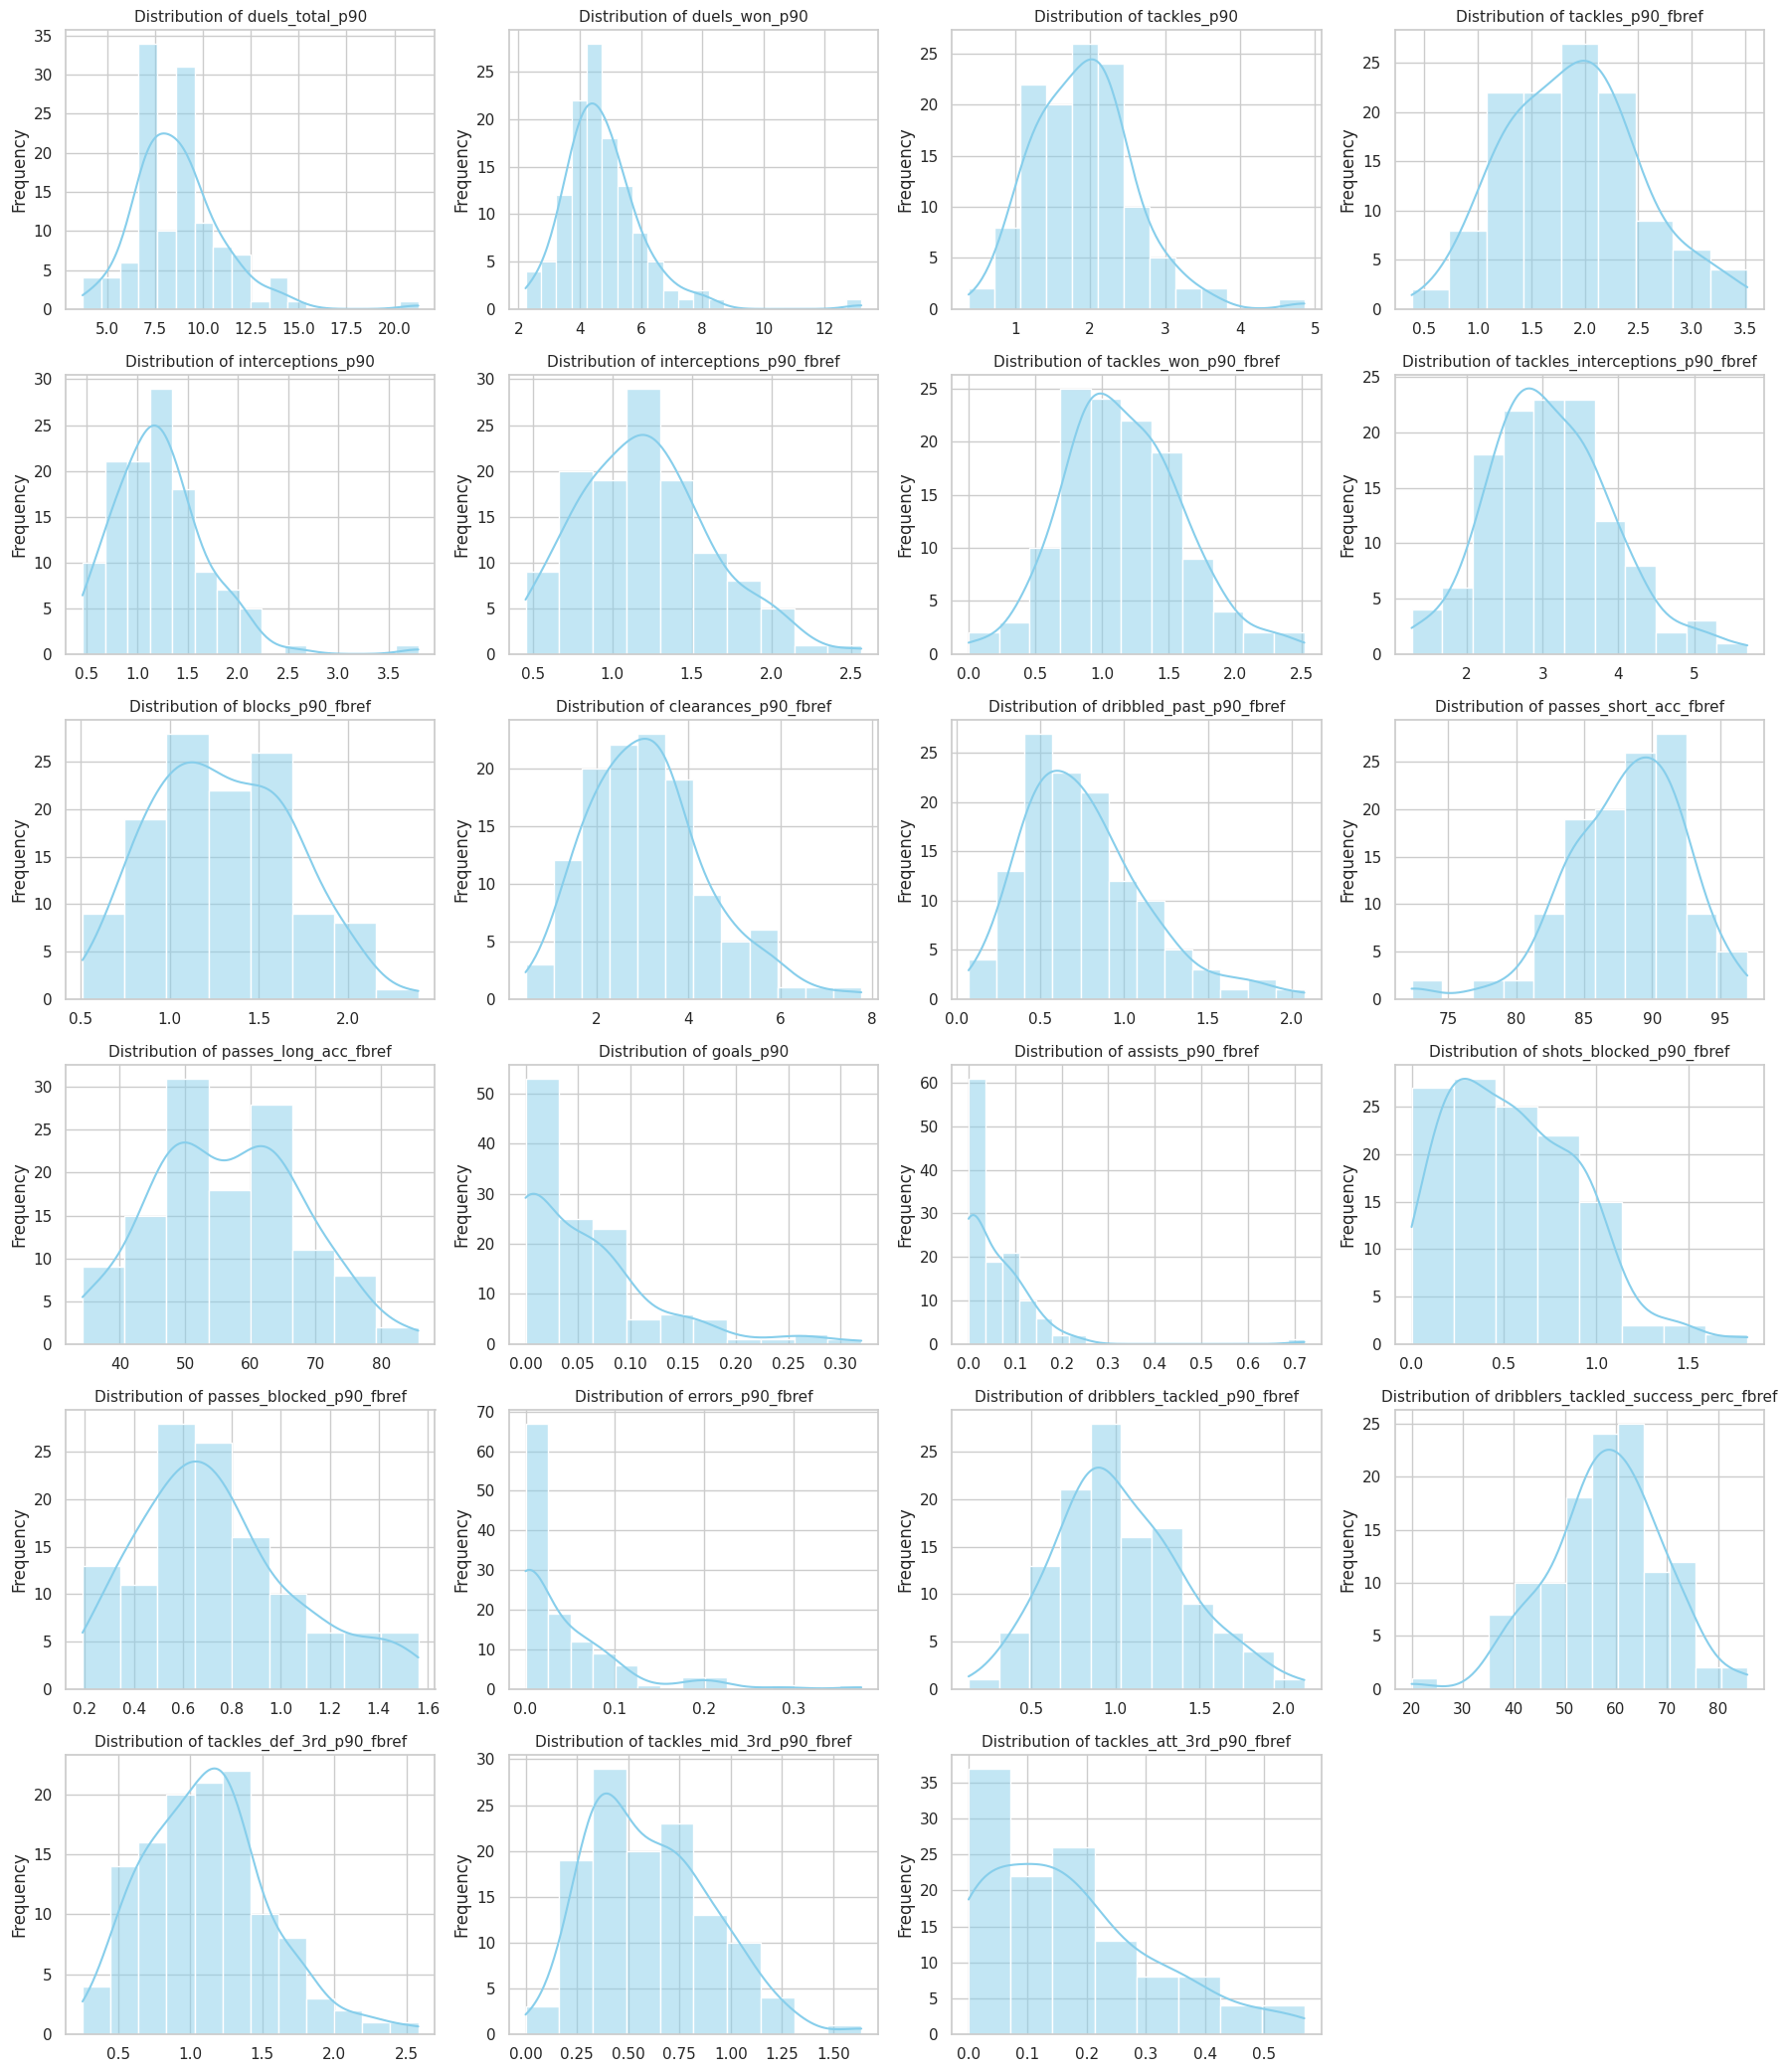

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set Seaborn style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (18, 14)

# Load preprocessed Ligue 1 defenders dataset
try:
    df_defenders_renamed = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed Ligue 1 defender dataset loaded successfully for EDA.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_preprocessed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error while loading dataset: {e}")
    exit()

# Key features for tactical profiling
key_features_defenders = [
    'duels_total_p90',
    'duels_won_p90',
    'tackles_p90',
    'tackles_p90_fbref',
    'interceptions_p90',
    'interceptions_p90_fbref',
    'tackles_won_p90_fbref',
    'tackles_interceptions_p90_fbref',
    'blocks_p90_fbref',
    'clearances_p90_fbref',
    'dribbled_past_p90_fbref',
    'passes_short_acc_fbref',
    'passes_long_acc_fbref',
    'goals_p90',
    'assists_p90_fbref',
    'shots_blocked_p90_fbref',
    'passes_blocked_p90_fbref',
    'errors_p90_fbref',
    'dribblers_tackled_p90_fbref',
    'dribblers_tackled_success_perc_fbref',
    'tackles_def_3rd_p90_fbref',
    'tackles_mid_3rd_p90_fbref',
    'tackles_att_3rd_p90_fbref'
]

# Setup subplot grid
num_features = len(key_features_defenders)
ncols = 4
nrows = (num_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
axes = axes.flatten()

# Plot distributions
for i, feature in enumerate(key_features_defenders):
    if feature in df_defenders_renamed.columns:
        sns.histplot(data=df_defenders_renamed, x=feature, kde=True, ax=axes[i], color='skyblue')
        axes[i].set_title(f"Distribution of {feature}", fontsize=11)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Frequency")
    else:
        print(f"⚠️ Warning: Feature '{feature}' not found. Skipping plot.")
        fig.delaxes(axes[i])

# Remove any unused subplots
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#Key Takeaways from the Distribution Plots – Ligue 1 DEFENDERS

These visualizations give us a solid glimpse into how the Ligue 1 defenders operate across the pitch. From defending to distribution, here’s what stands out:

#Defensive Actions & Involvement

Duels & Tackles

*   **Duels Total (p90):** The distribution is fairly spread out, but peaks around 6-8 duels per 90, with a tail extending towards higher numbers (up to around 15). This suggests a core group with moderate duel involvement and a smaller group of players who are much more active in duels.
*   **Duels Won (p90):** Similar to total duels, the distribution is right-skewed, peaking around 3-5 duels won per 90. There are players winning significantly more duels, indicating strong one-on-one defensive capabilities in a segment of the league.
*   **Tackles (API p90) & Tackles (FBref p90):** Both API and FBref tackle metrics show similar distributions, generally clustered below 2.5 tackles per 90, with a few players making over 3. There's good agreement between the two sources on the distribution shape for this core defensive action.
*   **Tackles Won (FBref p90):** This metric is also right-skewed, with most players winning between 1 and 2 tackles per 90. A few defenders stand out with higher tackles won rates.
*   **Tackles + Interceptions (FBref p90):** This combined metric shows a range from around 2 to 7 per 90, with a peak in the lower half of this range. It reflects the overall defensive activity level of the players.

Interceptions

*   **Interceptions (API p90) & Interceptions (FBref p90):** Both API and FBref interceptions distributions are heavily skewed towards lower values, with most players making under 1.5 interceptions per 90. A few players show higher interception rates, indicating a strength in reading the game and cutting off passes.

Blocks, Clearances & Errors

*   **Blocks (FBref p90):** The distribution of blocks is also skewed right, with most defenders making between 0.5 and 1.5 blocks per 90. Some players perform significantly more blocks, suggesting a role in blocking shots or passes.
*   **Shots Blocked (FBref p90):** Heavily skewed towards zero, with most players blocking very few shots per 90. Only a small number of defenders show a notable rate of shot blocking.
*   **Passes Blocked (FBref p90):** Similar to shots blocked, this metric is skewed towards lower values, with most players blocking under 1 pass per 90.
*   **Clearances (FBref p90):** Clearances show a wider distribution, ranging from under 2 to over 7 per 90, similar to the La Liga observations. This highlights players who are primarily focused on clearing the ball out of dangerous areas.
*   **Errors (FBref p90):** The distribution is heavily concentrated at zero, with almost all defenders having very few errors per 90, indicating a high level of reliability.
*   **Dribbled Past (FBref p90):** Skewed towards lower values, with most defenders being dribbled past less than once per 90. This suggests defenders in Ligue 1 are generally effective in one-on-one situations.

#Distribution & Passing

Passing Accuracy

*   **Passes Short Accuracy (FBref %) & Passes Medium Accuracy (FBref %):** Both short and medium passing accuracy distributions are clustered at high percentages, with most defenders above 85-90%. This indicates reliable short and medium passing among Ligue 1 defenders.
*   **Passes Long Accuracy (FBref %):** Long passing accuracy shows a broader spread, with a peak around 50-60% and a tail extending to higher percentages. This suggests a varied approach to long passing, with some defenders being much more accurate than others.

Attacking Contribution

*   **Goals (p90):** Highly skewed towards zero, as expected for defenders. Very few defenders score regularly, with most averaging below 0.1 goals per 90.
*   **Assists (p90):** Similar to goals, assists are rare for defenders, with the distribution heavily concentrated at zero.

I am creating a heatmap to visualize correlations between tactical features

-This helps identify which stats tend to move together and which ones are independent

-Useful to understand potential clusters and avoid feature redundancy

✅ Preprocessed Ligue 1 defender dataset loaded successfully for correlation analysis.


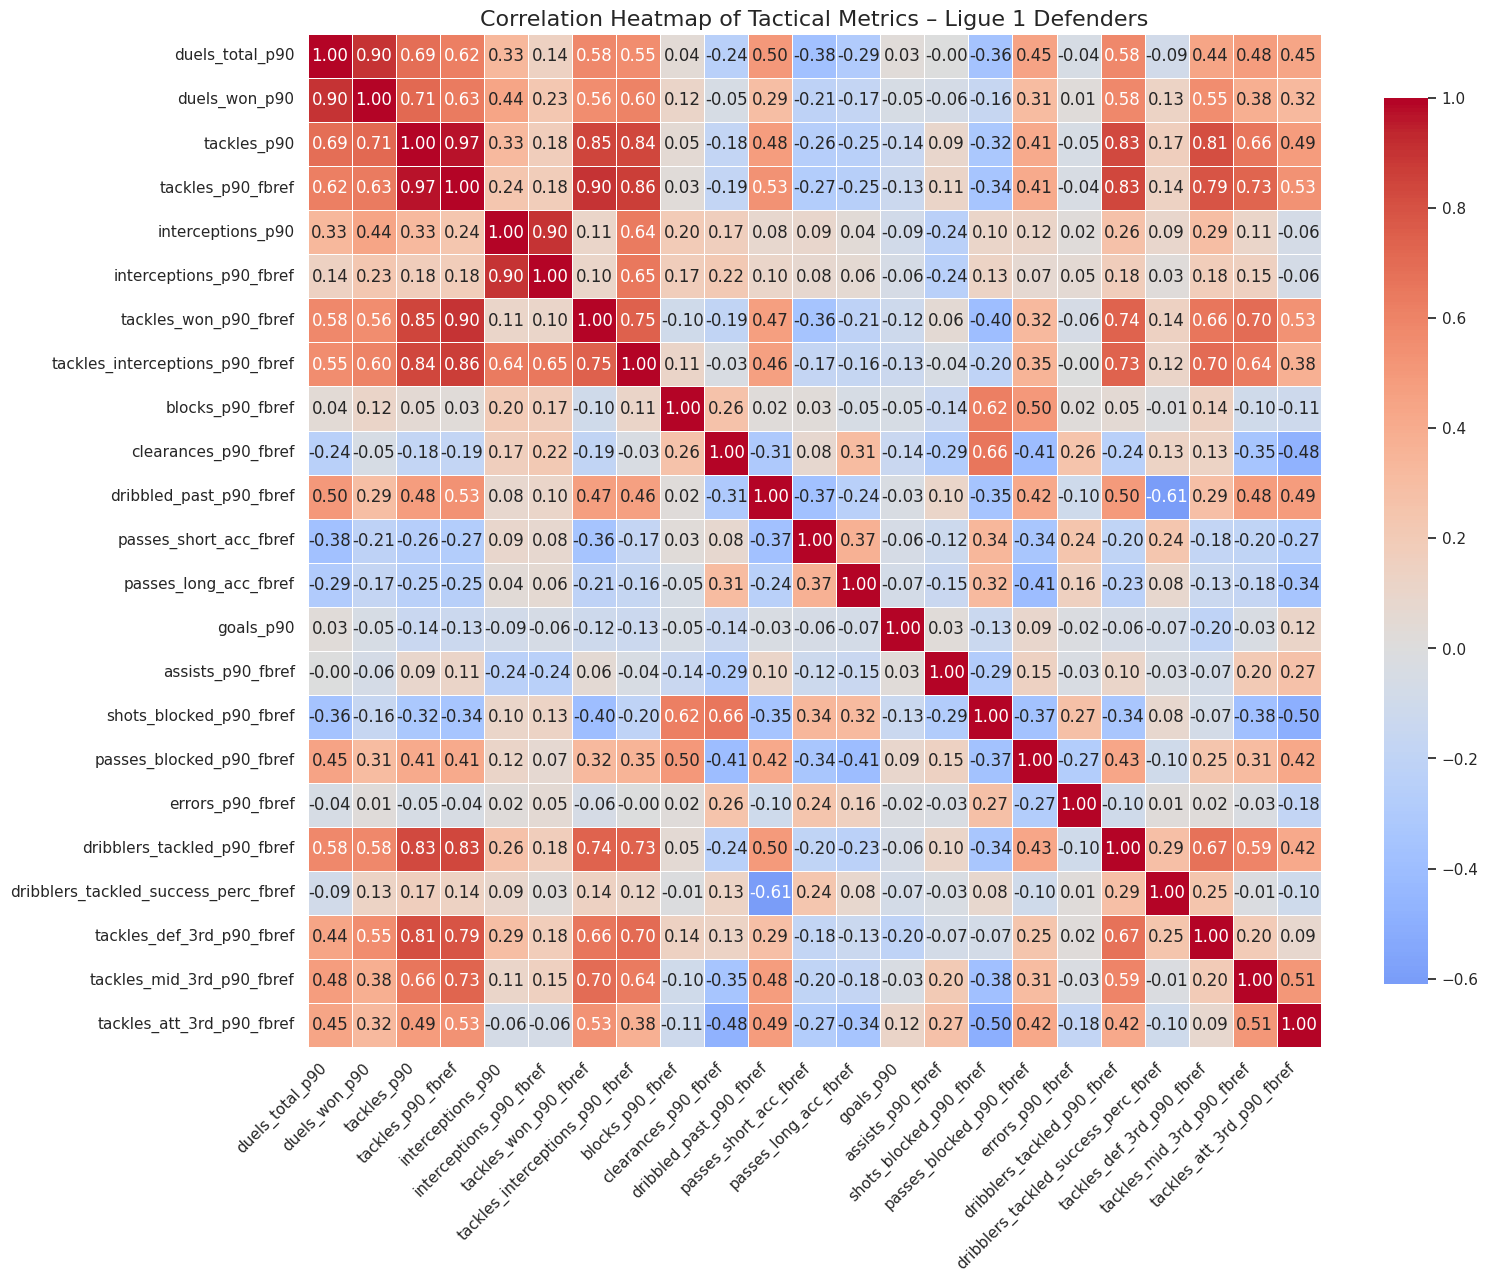

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Seaborn style for clean visuals
sns.set(style="whitegrid")

# Load Ligue 1 preprocessed defender dataset
try:
    df_defenders_renamed = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed Ligue 1 defender dataset loaded successfully for correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists and has been preprocessed.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")
    exit()

# Define features for correlation analysis
corr_features = [
    'duels_total_p90',
    'duels_won_p90',
    'tackles_p90',
    'tackles_p90_fbref',
    'interceptions_p90',
    'interceptions_p90_fbref',
    'tackles_won_p90_fbref',
    'tackles_interceptions_p90_fbref',
    'blocks_p90_fbref',
    'clearances_p90_fbref',
    'dribbled_past_p90_fbref',
    'passes_short_acc_fbref',
    'passes_long_acc_fbref',
    'goals_p90',
    'assists_p90_fbref',
    'shots_blocked_p90_fbref',
    'passes_blocked_p90_fbref',
    'errors_p90_fbref',
    'dribblers_tackled_p90_fbref',
    'dribblers_tackled_success_perc_fbref',
    'tackles_def_3rd_p90_fbref',
    'tackles_mid_3rd_p90_fbref',
    'tackles_att_3rd_p90_fbref'
]

# Check that all selected columns exist
existing_corr_features = [feature for feature in corr_features if feature in df_defenders_renamed.columns]

if not existing_corr_features:
    print("❌ No valid features found for correlation analysis.")
else:
    corr_matrix = df_defenders_renamed[existing_corr_features].corr()

    plt.figure(figsize=(16, 14))
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap='coolwarm',
        center=0,
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": .75}
    )
    plt.title("Correlation Heatmap of Tactical Metrics – Ligue 1 Defenders", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# Observations from the Correlation Heatmap – Ligue 1 Defenders

The heatmap reveals how different defensive and passing metrics relate to each other for Ligue 1 defenders. Here are some key observations and what they suggest about defender roles:

# Defensive Actions & Involvement:

*   **Duels and Tackles:** As expected, `duels_total_p90` and `duels_won_p90` are highly correlated (around 0.90), indicating that defenders involved in many duels also tend to win a high proportion of them. `tackles_p90` (both API and FBref versions) show strong correlations with `duels_total_p90` and `duels_won_p90`, and very strong correlation with each other (around 0.97), confirming consistency between the data sources. `tackles_won_p90_fbref` is also strongly correlated with total tackles. This suggests a group of players who actively engage in ground duels and are effective at winning the ball.
*   **Tackles and Interceptions:** `tackles_interceptions_p90_fbref` shows strong positive correlations with both `tackles_p90_fbref` (around 0.86) and `interceptions_p90_fbref` (around 0.65), as expected since it's a combined metric. The API `tackles_p90` and `interceptions_p90` also show a moderate positive correlation (around 0.33). This highlights players who are active in both direct ball winning (tackles) and reading the game to cut off passes (interceptions).

# Defensive Coverage Metrics:

*   Metrics like `blocks_p90_fbref` and `clearances_p90_fbref` show moderate positive correlations with each other (around 0.26). `shots_blocked_p90_fbref` and `passes_blocked_p90_fbref` are strongly correlated with `blocks_p90_fbref` (around 0.62 and 0.50 respectively). This indicates a set of actions related to preventing threats closer to the goal, often involving positioning and reacting to incoming shots or passes.
*   `dribbled_past_p90_fbref` shows a negative correlation with `dribblers_tackled_success_perc_fbref` (around -0.61), which is logical; players who are successfully tackled less often are also dribbled past less often.

# Passing Metrics:

*   Passing accuracy metrics (`passes_short_acc_fbref`, `passes_medium_acc_fbref`, `passes_long_acc_fbref`) generally show low to moderate correlations with most defensive actions. This confirms that a defender's passing proficiency is relatively independent of their defensive intensity.
*   Interestingly, `passes_short_acc_fbref` and `passes_long_acc_fbref` have a relatively low correlation with each other (around 0.08), suggesting that proficiency in short passing does not automatically translate to proficiency in long passing, and vice versa. This could indicate defenders specializing in different types of distribution.
*   `passes_blocked_p90_fbref` shows a moderate negative correlation with `clearances_p90_fbref` (around -0.41) and `shots_blocked_p90_fbref` (around -0.37). This might suggest that defenders who are more focused on clearing the ball quickly or blocking shots in congested areas are less likely to have their passes blocked, possibly because they attempt fewer complex or progressive passes.

# Attacking Contribution:

*   `goals_p90` and `assists_p90_fbref` show very weak correlations with most defensive and passing metrics, as is typical for defenders. Their attacking contributions are likely infrequent and not strongly tied to their primary defensive or passing styles.

# Tactical Insight from Correlations:

Based on these correlations, we can anticipate that clustering might reveal distinct defender profiles related to:

*   **Active Ball-Winners:** Players with high numbers in duels, tackles, and tackles won.
*   **Positional/Coverage Defenders:** Players with higher rates in interceptions, blocks, and clearances, potentially less involved in direct duels but strong in reading the game and protecting the goal area.
*   **Ball-Playing Defenders:** Players who stand out in passing accuracy metrics, potentially with different proficiencies in short vs. long distribution, regardless of their defensive volume.

I am plotting boxplots to detect outliers and visualize distribution spread.
This helps identify which players (or roles) stand out significantly from the average behavior.

✅ Preprocessed Ligue 1 defender dataset loaded successfully for EDA.

--- Generating Boxplot Visualizations ---


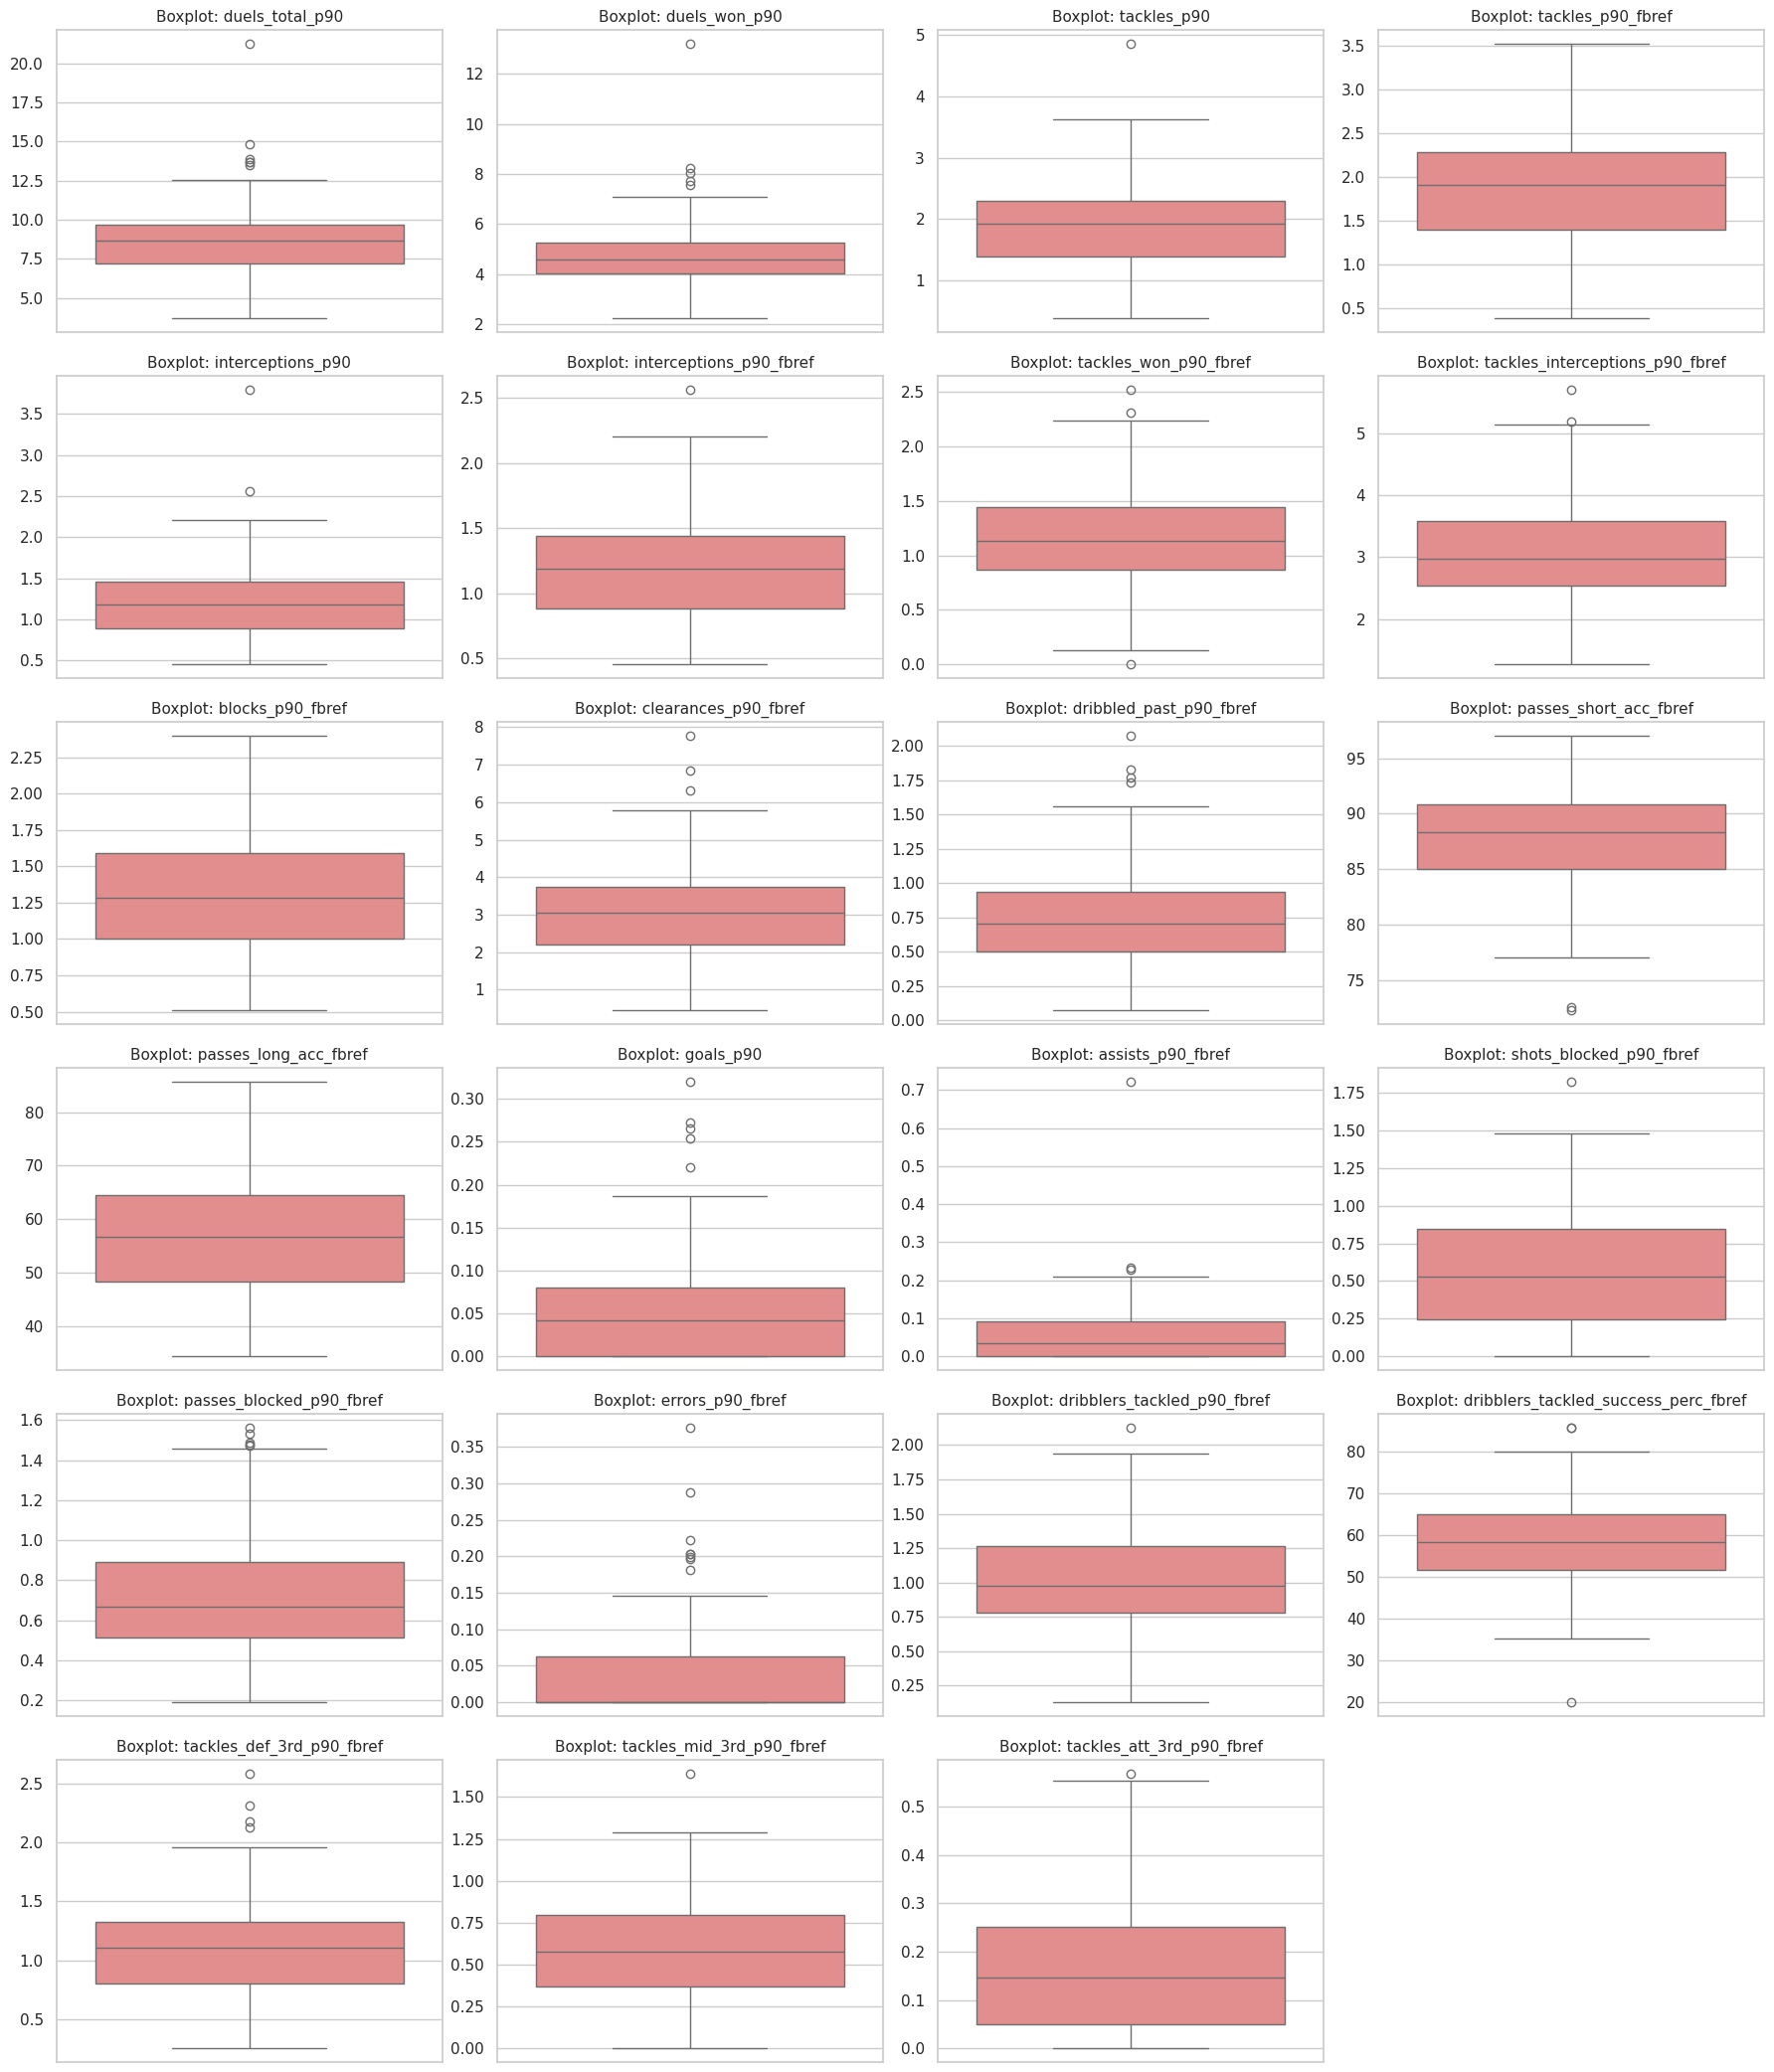

✅ Boxplot visualizations generated.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Seaborn style setup
sns.set(style="whitegrid")

# Load preprocessed Ligue 1 defender dataset
try:
    df_defenders_renamed = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed Ligue 1 defender dataset loaded successfully for EDA.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_preprocessed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error while loading dataset: {e}")
    exit()

# List of key metrics to plot — same tactical features used in La Liga EDA
analysis_features = [
    'duels_total_p90',
    'duels_won_p90',
    'tackles_p90',
    'tackles_p90_fbref',
    'interceptions_p90',
    'interceptions_p90_fbref',
    'tackles_won_p90_fbref',
    'tackles_interceptions_p90_fbref',
    'blocks_p90_fbref',
    'clearances_p90_fbref',
    'dribbled_past_p90_fbref',
    'passes_short_acc_fbref',
    'passes_long_acc_fbref',
    'goals_p90',
    'assists_p90_fbref',
    'shots_blocked_p90_fbref',
    'passes_blocked_p90_fbref',
    'errors_p90_fbref',
    'dribblers_tackled_p90_fbref',
    'dribblers_tackled_success_perc_fbref',
    'tackles_def_3rd_p90_fbref',
    'tackles_mid_3rd_p90_fbref',
    'tackles_att_3rd_p90_fbref',
]

# Filter only existing columns
existing_features = [f for f in analysis_features if f in df_defenders_renamed.columns]

if not existing_features:
    print("❌ No valid features found for boxplot analysis.")
else:
    print("\n--- Generating Boxplot Visualizations ---")
    num_plots = len(existing_features)
    ncols = 4
    nrows = (num_plots + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4.5, nrows * 3.5))
    axes = axes.flatten()

    for i, feature in enumerate(existing_features):
        sns.boxplot(data=df_defenders_renamed, y=feature, ax=axes[i], color='lightcoral')
        axes[i].set_title(f"Boxplot: {feature}", fontsize=11)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    print("✅ Boxplot visualizations generated.")


# Boxplot Summary – Ligue 1 DEFENDERS

# Duels & Tackles:

The boxplots for `duels_total_p90`, `duels_won_p90`, and `tackles_p90` (both API and FBref) show a range of engagement levels. Most defenders fall within a central box, but there are notable outliers with significantly higher values, indicating players who are particularly active and successful in ground duels and tackling. `tackles_won_p90_fbref` shows a similar pattern with a concentration of players winning a moderate number of tackles per 90, and outliers who win significantly more.

# Interceptions & Defensive Actions:

The boxplots for `interceptions_p90` (API and FBref) and `tackles_interceptions_p90_fbref` are generally skewed towards lower values, with a few outliers showing higher rates of interceptions or combined defensive actions. This suggests that while most defenders contribute to reading the game, a smaller group excels in proactively cutting off passes and combining tackles with interceptions.

# Defensive Coverage Metrics:

The boxplots for `blocks_p90_fbref` and `clearances_p90_fbref` show some variation in the data spread, with several outliers indicating defenders who perform a significantly higher number of blocks or clearances. This points to players who are more focused on preventing shots and clearing the ball from dangerous areas, potentially acting as more traditional, deep-lying defenders. `shots_blocked_p90_fbref` and `passes_blocked_p90_fbref` also show outliers, particularly in passes blocked, suggesting some defenders are more active in disrupting opposition passing lanes.

# Passing Accuracy:

*   **passes_short_acc_fbref:** The boxplot for short pass accuracy is tightly clustered at high percentages, with a high median. This indicates that most Ligue 1 defenders are highly reliable with their short passing.
*   **passes_long_acc_fbref:** The boxplot for long pass accuracy shows a much wider spread and a lower median compared to short passes. This highlights significant variation in long passing ability, with some defenders being much more proficient at accurate long distribution than others. `passes_medium_acc_fbref` falls somewhere between short and long accuracy in terms of spread and median.

# Attacking Contribution:

As expected for defenders, the boxplots for `goals_p90` and `assists_p90_fbref` are heavily skewed towards zero, with a low median and limited spread. There are a few potential outliers who might contribute more significantly in terms of goals or assists, likely from set pieces or overlapping runs.

# Efficiency/Rate Metrics:

`dribblers_tackled_success_perc_fbref` shows a wide distribution, suggesting variation in how successful defenders are at tackling players attempting to dribble past them. `dribbled_past_p90_fbref` is skewed towards lower values, indicating most defenders are not easily dribbled past, though outliers exist.

# Overall Insights:

The boxplots confirm the presence of variation in defender performance across key tactical metrics in Ligue 1. They highlight core competencies shared by most defenders (like short passing accuracy and low error rates) but also reveal areas where players differentiate themselves, such as high defensive volume (duels, tackles), proactive defending (interceptions), defensive coverage (blocks, clearances), and long passing ability. The outliers observed in several plots suggest that there are players with distinct skill sets that deviate significantly from the average, which will be important to consider during clustering.

#3. DATA CLEANING

#3.1.1 Data Cleaning-LIGUE 1 DEFENDERS

This part ensures my dataset is clean, consistent, and ready for clustering. I’ll go through key checks.

In [ ]:
import pandas as pd

# Load the preprocessed Ligue 1 defender dataset
try:
    df_defenders_renamed = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed Ligue 1 defender dataset loaded successfully for data type check.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Check and display data types of each column
print("\n📋 Data types of the preprocessed Ligue 1 defender dataset:")
print(df_defenders_renamed.dtypes)


✅ Preprocessed Ligue 1 defender dataset loaded successfully for data type check.

📋 Data types of the preprocessed Ligue 1 defender dataset:
name                                object
team                                object
position                            object
minutes                            float64
duels_total_api                    float64
                                    ...   
passes_blocked_p90_fbref           float64
interceptions_p90_fbref            float64
tackles_interceptions_p90_fbref    float64
clearances_p90_fbref               float64
errors_p90_fbref                   float64
Length: 81, dtype: object


It looks like we have correct data types as name, team and position are object whereas the rest are float64.

In [ ]:
import pandas as pd

# Load the preprocessed Ligue 1 defender dataset
try:
    df_defenders_renamed = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed Ligue 1 defender dataset loaded successfully for duplicate check.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Check for duplicated rows
num_duplicates = df_defenders_renamed.duplicated().sum()
print(f"\n🔍 Number of duplicated rows in the preprocessed Ligue 1 defender dataset: {num_duplicates}")

if num_duplicates == 0:
    print("✅ No duplicate rows found. The dataset is ready for further analysis.")
else:
    print("⚠️ Duplicate rows found. Consider reviewing and deduplicating before clustering.")


✅ Preprocessed Ligue 1 defender dataset loaded successfully for duplicate check.

🔍 Number of duplicated rows in the preprocessed Ligue 1 defender dataset: 0
✅ No duplicate rows found. The dataset is ready for further analysis.


O Duplicates.

In [ ]:
import pandas as pd

# Load the preprocessed Ligue 1 defender dataset
try:
    df_defenders_renamed = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed Ligue 1 defender dataset loaded successfully for unique value check.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Display number of unique player names and teams
print("\n🔢 Unique player names:", df_defenders_renamed['name'].nunique())
print("🏟️ Unique teams:", df_defenders_renamed['team'].nunique())


✅ Preprocessed Ligue 1 defender dataset loaded successfully for unique value check.

🔢 Unique player names: 122
🏟️ Unique teams: 18


In [ ]:
import pandas as pd

# Load the preprocessed Ligue 1 defender dataset
try:
    df_defenders_renamed = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed Ligue 1 defender dataset loaded successfully for final missing value check.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure the file exists (it should be generated by the previous preprocessing step).")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Check for missing values
missing_values_final = df_defenders_renamed.isnull().sum()
missing_values_summary = missing_values_final[missing_values_final > 0].sort_values(ascending=False)

if missing_values_summary.empty:
    print("\n✅ No missing values found in the preprocessed dataset. Data is clean!")
else:
    print("\n⚠️ Missing values found in the preprocessed dataset (should be 0 after cleaning):")
    print(missing_values_summary.to_string())
    print("\nPlease recheck preprocessing and rerun the cleaning pipeline if needed.")


✅ Preprocessed Ligue 1 defender dataset loaded successfully for final missing value check.

✅ No missing values found in the preprocessed dataset. Data is clean!


In [ ]:
import pandas as pd

# Load the preprocessed Ligue 1 defender dataset
try:
    df_defenders_preprocessed = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed Ligue 1 defender dataset loaded successfully for feature selection.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_preprocessed.csv' not found.")
    print("Please ensure this file has been generated by the previous preprocessing step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred during file loading: {e}")
    exit()

# Select clustering-relevant metrics (per-90 and % based)
selected_metrics_for_clustering = [
    'duels_total_p90', 'duels_won_p90', 'interceptions_p90', 'interceptions_p90_fbref',
    'tackles_p90', 'tackles_p90_fbref', 'tackles_won_p90_fbref', 'tackles_interceptions_p90_fbref',
    'blocks_p90_fbref', 'shots_blocked_p90_fbref', 'passes_blocked_p90_fbref', 'clearances_p90_fbref',
    'dribbled_past_p90_fbref', 'errors_p90_fbref', 'passes_total_p90', 'passes_completed_p90_fbref',
    'passes_short_cmp_p90_fbref', 'passes_short_att_p90_fbref', 'passes_medium_cmp_p90_fbref',
    'passes_medium_att_p90_fbref', 'passes_long_cmp_p90_fbref', 'passes_long_att_p90_fbref',
    'passes_total_accuracy_api', 'passes_short_acc_fbref', 'passes_medium_acc_fbref',
    'passes_long_acc_fbref', 'goals_p90', 'assists_p90_fbref', 'dribblers_tackled_success_perc_fbref',
    'dribblers_tackled_p90_fbref', 'tackles_def_3rd_p90_fbref', 'tackles_mid_3rd_p90_fbref',
    'tackles_att_3rd_p90_fbref'
]

# Filter existing columns
existing_selected_metrics = [col for col in selected_metrics_for_clustering if col in df_defenders_preprocessed.columns]

if len(existing_selected_metrics) != len(selected_metrics_for_clustering):
    missing = set(selected_metrics_for_clustering) - set(existing_selected_metrics)
    print(f"⚠️ Warning: Missing metrics from dataset: {missing}")
    print("Please verify preprocessing steps.")

df_features_for_clustering = df_defenders_preprocessed[existing_selected_metrics].copy()
print(f"✅ Selected {len(existing_selected_metrics)} features for clustering.")

# Save to CSV
output_filename = "ligue1_defenders_2023_24_selected_metrics.csv"
df_features_for_clustering.to_csv(output_filename, index=False)
print(f"✅ Selected features dataset saved as: {output_filename}")

# Display summary
print("\n--- Summary of Features for Clustering ---")
print(f"Final dataset shape: {df_features_for_clustering.shape}")
print("\nColumn types:")
print(df_features_for_clustering.dtypes.value_counts())
print("\nFirst 5 rows of the features for clustering:")
print(df_features_for_clustering.head().to_string())


✅ Preprocessed Ligue 1 defender dataset loaded successfully for feature selection.
✅ Selected 33 features for clustering.
✅ Selected features dataset saved as: ligue1_defenders_2023_24_selected_metrics.csv

--- Summary of Features for Clustering ---
Final dataset shape: (122, 33)

Column types:
float64    33
Name: count, dtype: int64

First 5 rows of the features for clustering:
   duels_total_p90  duels_won_p90  interceptions_p90  interceptions_p90_fbref  tackles_p90  tackles_p90_fbref  tackles_won_p90_fbref  tackles_interceptions_p90_fbref  blocks_p90_fbref  shots_blocked_p90_fbref  passes_blocked_p90_fbref  clearances_p90_fbref  dribbled_past_p90_fbref  errors_p90_fbref  passes_total_p90  passes_completed_p90_fbref  passes_short_cmp_p90_fbref  passes_short_att_p90_fbref  passes_medium_cmp_p90_fbref  passes_medium_att_p90_fbref  passes_long_cmp_p90_fbref  passes_long_att_p90_fbref  passes_total_accuracy_api  passes_short_acc_fbref  passes_medium_acc_fbref  passes_long_acc_fbref  goal

#4. FEATURE ENGINEERING

#4.1.1 Feature engineering -LIGUE 1 DEFENDERS

#One-hot encoding

This step is crucial for preparing the 'team' categorical variable for machine learning. By converting team names into a numerical, binary format through one-hot encoding, I ensure that the clustering algorithm can properly interpret and utilize team affiliation as a factor in grouping players, maintaining consistency with the approach taken for other positions like defenders.

In [ ]:
import pandas as pd

# Step 1: Load preprocessed Ligue 1 defender dataset
try:
    df_preprocessed = pd.read_csv("ligue1_defenders_2023_24_preprocessed.csv")
    print("✅ Preprocessed Ligue 1 defender dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_preprocessed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# Step 2: Perform one-hot encoding on the 'team' column
df_encoded = pd.get_dummies(df_preprocessed, columns=['team'], drop_first=True)
print("✅ One-hot encoding applied to 'team' column.")

# Step 3: Verify that 'team' column has been removed
if 'team' in df_encoded.columns:
    print("❌ ERROR: 'team' column still present after encoding.")
    df_encoded.drop(columns=['team'], inplace=True)
    print("✅ Dropped 'team' column manually.")
else:
    print("✅ Original 'team' column removed successfully after encoding.")

# Step 4: Save final encoded dataset
output_file = "ligue1_defenders_2023_24_preprocessed_encoded_team.csv"
df_encoded.to_csv(output_file, index=False)
print(f"✅ Encoded Ligue 1 dataset saved as: {output_file}")

# Step 5: Preview encoded output
print("\n🔎 First 5 rows of encoded dataset:")
print(df_encoded.head().to_string())
print("\n📊 Columns in final encoded dataset:")
print(df_encoded.columns.tolist())


✅ Preprocessed Ligue 1 defender dataset loaded successfully.
✅ One-hot encoding applied to 'team' column.
✅ Original 'team' column removed successfully after encoding.
✅ Encoded Ligue 1 dataset saved as: ligue1_defenders_2023_24_preprocessed_encoded_team.csv

🔎 First 5 rows of encoded dataset:
                name  position  minutes  duels_total_api  duels_won_api  goals_total  shots_total  shots_on_target  dribbles_attempts  dribbles_success  touches_total  passes_total_api  passes_total_accuracy_api  tackles_api  interceptions_api  shots_on_target_perc  dribbles_success_perc             name_clean     team_clean      player_name_fbref nation_fbref  90s_played_fbref  passes_completed_total_fbref  passes_short_cmp_fbref  passes_short_att_fbref  passes_short_acc_fbref  passes_medium_cmp_fbref  passes_medium_att_fbref  passes_medium_acc_fbref  passes_long_cmp_fbref  passes_long_att_fbref  passes_long_acc_fbref  assists_fbref_total Nation_fbref_def  Age_fbref_def  Born_fbref_def  90s_fbre

In [ ]:
import pandas as pd

# Load one-hot encoded Ligue 1 defender dataset
try:
    df_defenders_preprocessed = pd.read_csv("ligue1_defenders_2023_24_preprocessed_encoded_team.csv")
    print("✅ Preprocessed Ligue 1 defender dataset (with optional team encoding) loaded successfully for feature selection.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_preprocessed_encoded_team.csv' not found.")
    print("Please ensure this file has been generated from the team encoding step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")
    exit()

# Refined metrics for clustering (correlation-filtered)
base_metrics_for_clustering = [
    'duels_total_p90', 'duels_won_p90', 'interceptions_p90', 'interceptions_p90_fbref',
    'tackles_p90', 'tackles_p90_fbref', 'tackles_won_p90_fbref', 'tackles_interceptions_p90_fbref',
    'blocks_p90_fbref', 'shots_blocked_p90_fbref', 'passes_blocked_p90_fbref',
    'clearances_p90_fbref', 'dribbled_past_p90_fbref',
    'passes_short_acc_fbref', 'passes_medium_acc_fbref', 'passes_long_acc_fbref',
    'goals_p90', 'assists_p90_fbref', 'dribblers_tackled_success_perc_fbref',
    'dribblers_tackled_p90_fbref', 'tackles_def_3rd_p90_fbref',
    'tackles_mid_3rd_p90_fbref', 'tackles_att_3rd_p90_fbref'
]

# Collect one-hot encoded team columns
team_encoded_cols = [col for col in df_defenders_preprocessed.columns if col.startswith('team_')]

# Final features list
selected_metrics_for_clustering = base_metrics_for_clustering + team_encoded_cols

# Identify identifier / categorical columns to exclude
columns_to_exclude = [
    'name', 'position', 'name_clean', 'team_clean', 'Player', 'Nation',
    'Nation_fbref_def', 'Age_fbref_def', 'Born_fbref_def'
]

# Drop those columns if present
existing_cols_to_exclude = [col for col in columns_to_exclude if col in df_defenders_preprocessed.columns]
df_features_for_clustering = df_defenders_preprocessed.drop(columns=existing_cols_to_exclude, errors='ignore').copy()

# Retain only selected metrics
df_features_for_clustering = df_features_for_clustering[
    [col for col in selected_metrics_for_clustering if col in df_features_for_clustering.columns]
].copy()

# Convert any boolean columns to float64
for col in df_features_for_clustering.select_dtypes(include='bool').columns:
    df_features_for_clustering[col] = df_features_for_clustering[col].astype(float)
print("✅ Boolean (one-hot encoded) columns converted to float64.")

# Final check for non-numeric leftovers
non_numeric_cols = df_features_for_clustering.select_dtypes(exclude=['float64', 'int64']).columns.tolist()
if non_numeric_cols:
    print(f"❌ Error: Non-numeric columns found: {non_numeric_cols}")
    exit()

print(f"✅ Selected {len(df_features_for_clustering.columns)} features for clustering (including team encoding).")

# Save to CSV
output_filename = "ligue1_defenders_2023_24_selected_metrics.csv"
df_features_for_clustering.to_csv(output_filename, index=False)
print(f"✅ Selected features dataset saved as: {output_filename}")

# Summary preview
print("\n--- Summary of Features for Clustering ---")
print(f"Final dataset shape: {df_features_for_clustering.shape}")
print("\nColumn types:")
print(df_features_for_clustering.dtypes.value_counts())
print("\nFirst 5 rows of the features for clustering:")
print(df_features_for_clustering.head().to_string())


✅ Preprocessed Ligue 1 defender dataset (with optional team encoding) loaded successfully for feature selection.
✅ Boolean (one-hot encoded) columns converted to float64.
✅ Selected 40 features for clustering (including team encoding).
✅ Selected features dataset saved as: ligue1_defenders_2023_24_selected_metrics.csv

--- Summary of Features for Clustering ---
Final dataset shape: (122, 40)

Column types:
float64    40
Name: count, dtype: int64

First 5 rows of the features for clustering:
   duels_total_p90  duels_won_p90  interceptions_p90  interceptions_p90_fbref  tackles_p90  tackles_p90_fbref  tackles_won_p90_fbref  tackles_interceptions_p90_fbref  blocks_p90_fbref  shots_blocked_p90_fbref  passes_blocked_p90_fbref  clearances_p90_fbref  dribbled_past_p90_fbref  passes_short_acc_fbref  passes_medium_acc_fbref  passes_long_acc_fbref  goals_p90  assists_p90_fbref  dribblers_tackled_success_perc_fbref  dribblers_tackled_p90_fbref  tackles_def_3rd_p90_fbref  tackles_mid_3rd_p90_fbref

#Standard Scaling of Numerical Features

Before applying clustering, we need to make sure all numerical features contribute equally. Some metrics are much larger in range than others , which can distort clustering results. I solve this using StandardScaler, which transforms each feature to have:

    Mean = 0

    Standard deviation = 1


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the selected features for clustering (already team-encoded)
try:
    df_features_for_clustering = pd.read_csv("ligue1_defenders_2023_24_selected_metrics.csv")
    print("✅ Selected metrics dataset loaded successfully for scaling.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_selected_metrics.csv' not found.")
    print("Please ensure this file was generated during the 'Feature Selection for Clustering' step.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# Initialize and apply StandardScaler
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_features_for_clustering)

# Convert back to DataFrame with original column names
df_scaled_features = pd.DataFrame(scaled_array, columns=df_features_for_clustering.columns)
print("✅ Numerical features successfully scaled using StandardScaler.")

# Save the scaled dataset
output_filename = "ligue1_defenders_2023_24_scaled_metrics.csv"
df_scaled_features.to_csv(output_filename, index=False)
print(f"✅ Scaled features dataset saved as: {output_filename}")

# Summary preview
print("\n--- Summary of Scaled Features ---")
print(f" Scaled dataset shape: {df_scaled_features.shape}")
print("\n Column types (should all be float64):")
print(df_scaled_features.dtypes.value_counts())
print("\n First 5 rows of scaled data:")
print(df_scaled_features.head().to_string())


✅ Selected metrics dataset loaded successfully for scaling.
✅ Numerical features successfully scaled using StandardScaler.
✅ Scaled features dataset saved as: ligue1_defenders_2023_24_scaled_metrics.csv

--- Summary of Scaled Features ---
 Scaled dataset shape: (122, 40)

 Column types (should all be float64):
float64    40
Name: count, dtype: int64

 First 5 rows of scaled data:
   duels_total_p90  duels_won_p90  interceptions_p90  interceptions_p90_fbref  tackles_p90  tackles_p90_fbref  tackles_won_p90_fbref  tackles_interceptions_p90_fbref  blocks_p90_fbref  shots_blocked_p90_fbref  passes_blocked_p90_fbref  clearances_p90_fbref  dribbled_past_p90_fbref  passes_short_acc_fbref  passes_medium_acc_fbref  passes_long_acc_fbref  goals_p90  assists_p90_fbref  dribblers_tackled_success_perc_fbref  dribblers_tackled_p90_fbref  tackles_def_3rd_p90_fbref  tackles_mid_3rd_p90_fbref  tackles_att_3rd_p90_fbref  team_Le Havre  team_Lens  team_Lille  team_Lorient  team_Lyon  team_Marseille  team_

#4.2.1 Final feature selection-LIGUE 1 DEFENDERS

✅ Scaled Ligue 1 features dataset loaded successfully for correlation analysis.


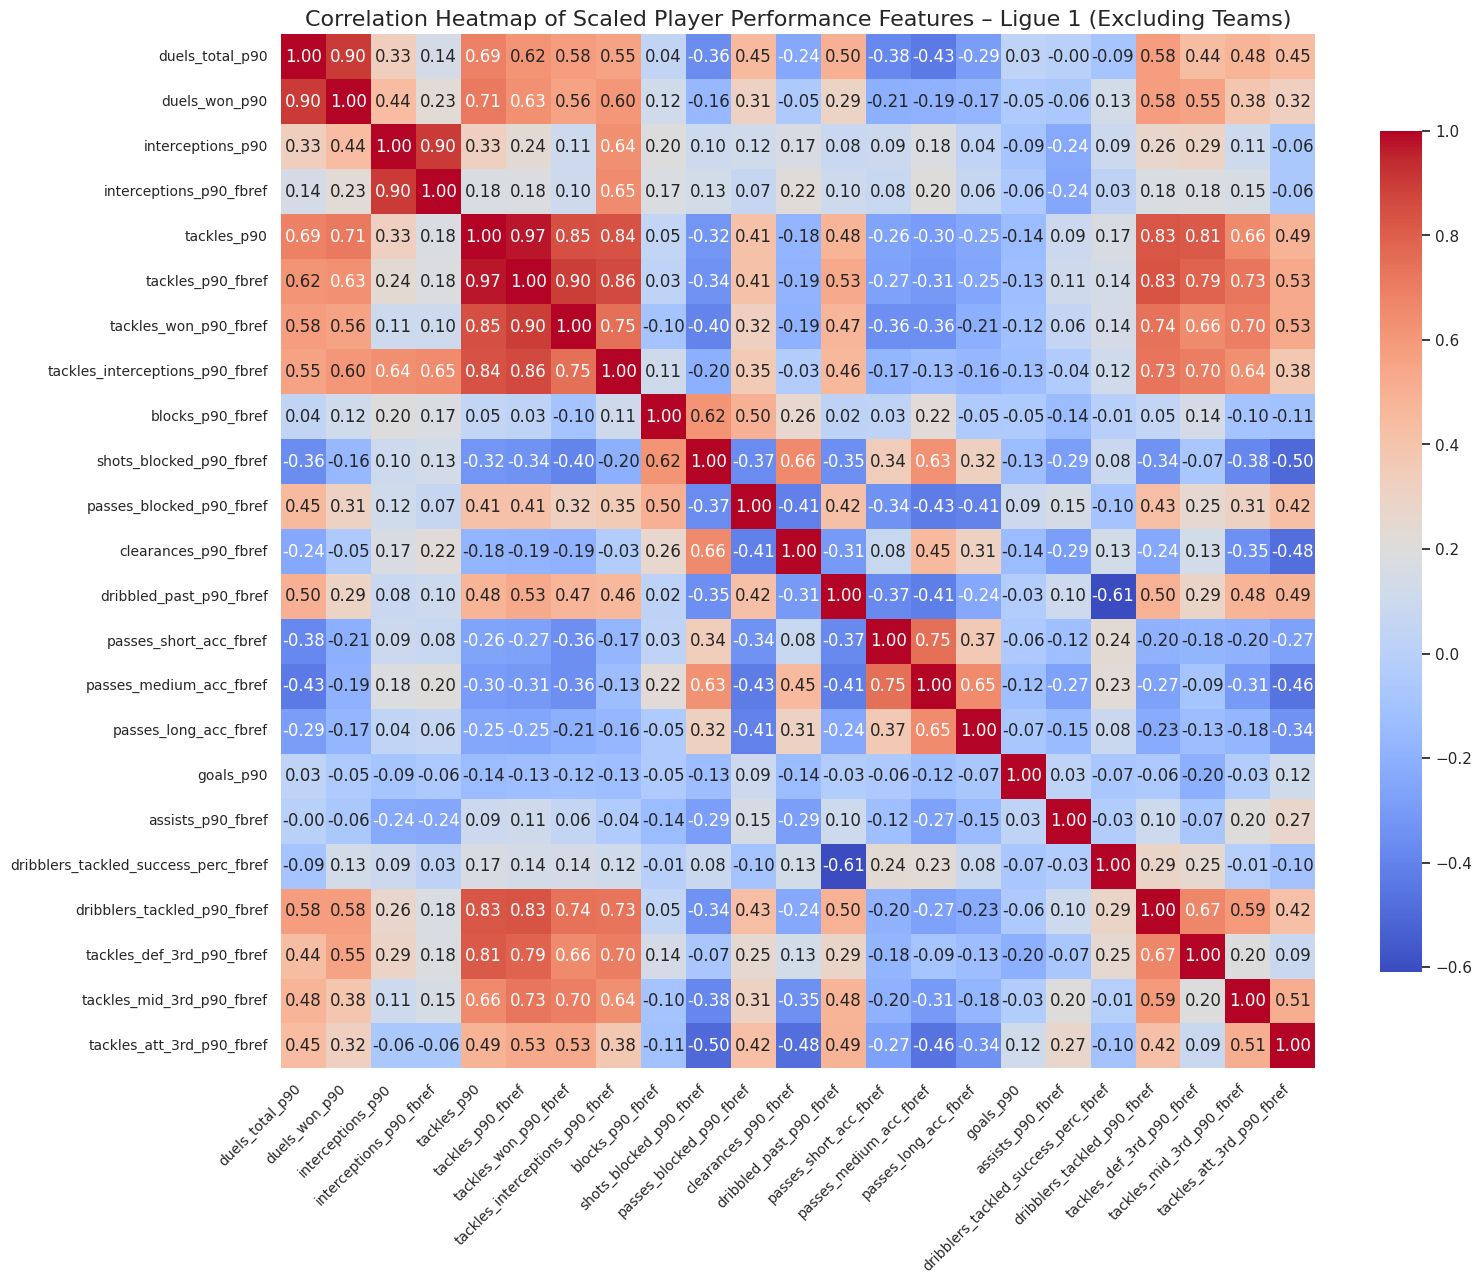

✅ Correlation heatmap of scaled Ligue 1 defender metrics generated (excluding team columns).


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the scaled Ligue 1 metrics
try:
    df_scaled_features = pd.read_csv("ligue1_defenders_2023_24_scaled_metrics.csv")
    print("✅ Scaled Ligue 1 features dataset loaded successfully for correlation analysis.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_scaled_metrics.csv' not found.")
    print("Ensure this file was generated by the 'Feature Scaling' step.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# Exclude one-hot encoded team columns for heatmap clarity
clustering_features_for_heatmap = [
    col for col in df_scaled_features.columns if not col.startswith('team_')
]

# Generate correlation matrix
corr_matrix = df_scaled_features[clustering_features_for_heatmap].corr()

# Visualize
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={'shrink': 0.7})
plt.title("Correlation Heatmap of Scaled Player Performance Features – Ligue 1 (Excluding Teams)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("✅ Correlation heatmap of scaled Ligue 1 defender metrics generated (excluding team columns).")


# Explanation of Metric Selection Based on Correlation Heatmap (Defenders)

The heatmap above reveals patterns of correlation between key defensive and passing metrics. Based on these relationships, we can discuss potential selections to retain features that are informative, tactically relevant, and not overly redundant for clustering Ligue 1 defenders.

### Observations and Potential Feature Considerations for Clustering:

Analyzing the correlations helps us understand which metrics capture similar aspects of a defender's game and which provide unique information.

*   **Duels (`duels_total_p90`, `duels_won_p90`):** These are highly correlated (around 0.90). While both are relevant to physical engagement, their strong correlation suggests that keeping both might introduce some redundancy. `duels_won_p90` might be slightly more informative as it focuses on successful outcomes.
*   **Tackles (`tackles_p90`, `tackles_p90_fbref`, `tackles_won_p90_fbref`):** The API (`tackles_p90`) and FBref (`tackles_p90_fbref`) total tackles are very highly correlated (around 0.97), indicating strong agreement between sources. `tackles_won_p90_fbref` is also highly correlated with `tackles_p90_fbref` (around 0.90). This cluster of tackle metrics captures different facets of tackling (attempts vs. success). Keeping `tackles_p90_fbref` (or `tackles_p90`) and `tackles_won_p90_fbref` would provide a good balance of volume and efficiency in tackling.
*   **Interceptions (`interceptions_p90`, `interceptions_p90_fbref`):** The API and FBref interceptions are highly correlated (around 0.90). Keeping one of these is likely sufficient to represent a player's ability to read the game and cut off passes.
*   **Combined Defensive Actions (`tackles_interceptions_p90_fbref`):** This metric shows strong correlations with both FBref tackles (around 0.86) and FBref interceptions (around 0.65). It serves as a good summary metric for overall defensive activity volume. Including it alongside separate tackle and interception metrics might be redundant, but it could also highlight players with a balanced contribution across both.
*   **Blocks (`blocks_p90_fbref`, `shots_blocked_p90_fbref`, `passes_blocked_p90_fbref`):** `shots_blocked_p90_fbref` and `passes_blocked_p90_fbref` are strongly correlated with `blocks_p90_fbref` (around 0.62 and 0.50). This suggests that `blocks_p90_fbref` can largely represent a player's blocking activity.
*   **Clearances (`clearances_p90_fbref`):** This metric shows moderate positive correlations with blocks (around 0.26) but is relatively independent of most tackling and interception metrics. It captures a distinct defensive action related to clearing danger from the box.
*   **Dribbled Past & Tackled Dribblers (`dribbled_past_p90_fbref`, `dribblers_tackled_p90_fbref`, `dribblers_tackled_success_perc_fbref`):** `dribbled_past_p90_fbref` has a strong negative correlation with `dribblers_tackled_success_perc_fbref` (around -0.61) and a moderate positive correlation with `dribblers_tackled_p90_fbref` (around 0.50). This set of metrics provides insight into a defender's effectiveness in one-on-one situations against dribblers. Keeping `dribbled_past_p90_fbref` and `dribblers_tackled_success_perc_fbref` could be a good way to capture both the volume of times dribbled past and the success rate when attempting to tackle a dribbler.
*   **Passing Accuracy (`passes_short_acc_fbref`, `passes_medium_acc_fbref`, `passes_long_acc_fbref`):** These accuracy metrics show low to moderate correlations with most defensive metrics, confirming their independent nature. The correlations among themselves are moderate (`passes_short_acc_fbref` with `passes_medium_acc_fbref` around 0.75, `passes_medium_acc_fbref` with `passes_long_acc_fbref` around 0.65), suggesting some relatedness but also distinctness in short, medium, and long passing proficiency. Retaining all three provides a detailed view of passing range accuracy.
*   **Attacking Contribution (`goals_p90`, `assists_p90_fbref`):** These metrics show generally weak correlations with defensive and passing metrics, as expected. They capture the rare but impactful attacking contributions of defenders.
*   **Errors (`errors_p90_fbref`):** This metric shows very low correlations with most other features, indicating that errors are largely independent of other performance volumes.

### Potential Metrics to Select for Clustering (Considering Balance and Redundancy):

Based on the above, a potential set of features for clustering that balances tactical relevance and avoids excessive multicollinearity could include:

*   `duels_won_p90` (or `duels_total_p90`)
*   `tackles_p90_fbref` (or `tackles_p90`) and `tackles_won_p90_fbref`
*   `interceptions_p90_fbref` (or `interceptions_p90`)
*   `blocks_p90_fbref`
*   `clearances_p90_fbref`
*   `dribbled_past_p90_fbref` and `dribblers_tackled_success_perc_fbref`
*   `passes_short_acc_fbref`, `passes_medium_acc_fbref`, `passes_long_acc_fbref`
*   `goals_p90`
*   `assists_p90_fbref`
*   `errors_p90_fbref`
*   Positional/Zone-specific tackle metrics (`tackles_def_3rd_p90_fbref`, `tackles_mid_3rd_p90_fbref`, `tackles_att_3rd_p90_fbref`) could be selected based on the desired focus – they show some distinct correlations with other defensive actions.

The inclusion of one-hot encoded team columns will also factor into the clustering, adding a dimension related to team style or quality.

#5. Preprocessing

#5.1.1 Preprocessing-PCA (Principal Component Analysis)- LIGUE 1 DEFENDERS

✅ Scaled features dataset loaded successfully for PCA.
✅ PCA performed. Transformed data shape: (122, 40)


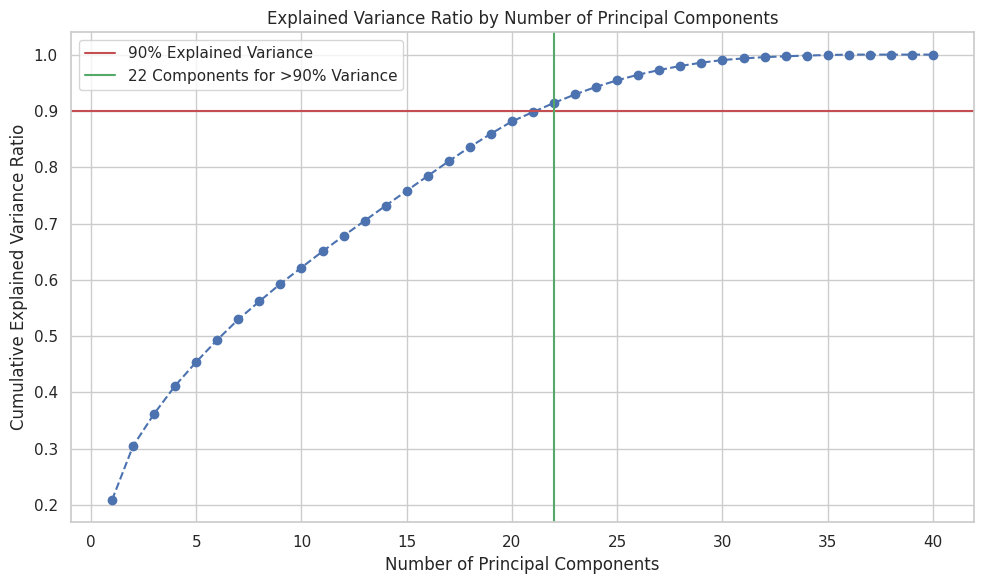

✅ Explained Variance Ratio plot generated.

Explained Variance Ratio per Principal Component:
PC1: 0.2090 (Cumulative: 0.2090)
PC2: 0.0960 (Cumulative: 0.3050)
PC3: 0.0571 (Cumulative: 0.3621)
PC4: 0.0499 (Cumulative: 0.4120)
PC5: 0.0421 (Cumulative: 0.4541)
PC6: 0.0394 (Cumulative: 0.4935)
PC7: 0.0362 (Cumulative: 0.5297)
PC8: 0.0321 (Cumulative: 0.5618)
PC9: 0.0312 (Cumulative: 0.5930)
PC10: 0.0289 (Cumulative: 0.6219)
PC11: 0.0286 (Cumulative: 0.6505)
PC12: 0.0276 (Cumulative: 0.6781)
PC13: 0.0268 (Cumulative: 0.7049)
PC14: 0.0268 (Cumulative: 0.7317)
PC15: 0.0265 (Cumulative: 0.7582)
PC16: 0.0263 (Cumulative: 0.7846)
PC17: 0.0261 (Cumulative: 0.8107)
PC18: 0.0253 (Cumulative: 0.8360)
PC19: 0.0235 (Cumulative: 0.8595)
PC20: 0.0219 (Cumulative: 0.8814)
PC21: 0.0166 (Cumulative: 0.8980)
PC22: 0.0163 (Cumulative: 0.9143)
PC23: 0.0150 (Cumulative: 0.9293)
PC24: 0.0135 (Cumulative: 0.9428)
PC25: 0.0116 (Cumulative: 0.9544)
PC26: 0.0100 (Cumulative: 0.9644)
PC27: 0.0082 (Cumulative: 0.972

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load scaled Ligue 1 feature dataset
try:
    df_scaled_features = pd.read_csv("ligue1_defenders_2023_24_scaled_metrics.csv")
    print("✅ Scaled features dataset loaded successfully for PCA.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_scaled_metrics.csv' not found.")
    print("Ensure this file was generated during the feature scaling step.")
    exit()
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")
    exit()

# Initialize and apply PCA
pca = PCA()
principal_components = pca.fit_transform(df_scaled_features)
df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])
print(f"✅ PCA performed. Transformed data shape: {df_pca.shape}")

# --- Explained Variance Ratio Plot ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(),
         marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='-', label='90% Explained Variance')

n_components_90_variance = (pca.explained_variance_ratio_.cumsum() < 0.90).sum() + 1
plt.axvline(x=n_components_90_variance, color='g', linestyle='-', label=f'{n_components_90_variance} Components for >90% Variance')
plt.legend()
plt.tight_layout()
plt.show()
print("✅ Explained Variance Ratio plot generated.")

# Display variance breakdown
print("\nExplained Variance Ratio per Principal Component:")
for i, variance in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {variance:.4f} (Cumulative: {pca.explained_variance_ratio_[:i+1].sum():.4f})")

# Save PCA-transformed dataset
output_filename = "ligue1_defenders_2023_24_pca_transformed.csv"
df_pca.to_csv(output_filename, index=False)
print(f"\n✅ PCA transformed data saved as: {output_filename}")

# Preview PCA results
print("\n🔍 First 5 rows of PCA-transformed data:")
print(df_pca.head().to_string())


# Breakdown of the PCA output:

Based on the PCA analysis performed on the scaled defender data:

The analysis reduced the dataset from 40 features to 40 principal components.
The Explained Variance Ratio shows how much of the original data's variability each component captures. The first principal component (PC1) explains about 20.90% of the variance, PC2 explains about 9.60%, and so on.
The Cumulative Explained Variance plot indicates that you need approximately 22 principal components to capture over 90% of the total variance in the original dataset.

### Brief Breakdown:

PCA revealed that a significant portion of the variability in the defender performance metrics can be captured by a smaller number of underlying dimensions (principal components). Specifically, using the first 22 components allows you to retain over 90% of the information from the original 40 features. This dimensionality reduction is beneficial for clustering by focusing on the most important patterns and potentially improving algorithm performance and interpretability.

The ligue1_defenders_2023_24_pca_transformed.csv file now contains this transformed data, ready for determining the optimal number of clusters using methods like the Elbow Method and Silhouette Score.

#5.2.1 ELBOW METHOD-LIGUE 1 DEFENDERS

✅ PCA transformed data loaded successfully for Elbow Method.
✅ Using the first 20 principal components for clustering analysis.
🔢 Calculating Inertia for K from 2 to 9...
✅ Inertia calculated for all tested K values.


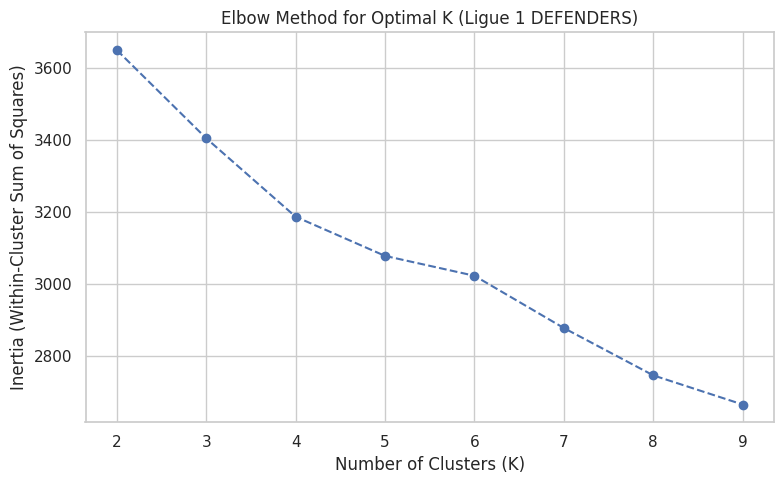

✅ Elbow Method plot generated. Look for the 'elbow' point to determine optimal K.


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load PCA-transformed Ligue 1 data
try:
    df_pca = pd.read_csv("ligue1_defenders_2023_24_pca_transformed.csv")
    print("✅ PCA transformed data loaded successfully for Elbow Method.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_pca_transformed.csv' not found.")
    print("Please ensure this file was generated by the PCA step.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# Decide number of components to use
n_components_for_clustering = 20
if n_components_for_clustering > df_pca.shape[1]:
    print(f"⚠️ Requested {n_components_for_clustering} components, but only {df_pca.shape[1]} are available.")
    n_components_for_clustering = df_pca.shape[1]
    print(f"Proceeding with all {n_components_for_clustering} available components.")

X_for_clustering = df_pca.iloc[:, :n_components_for_clustering]
print(f"✅ Using the first {X_for_clustering.shape[1]} principal components for clustering analysis.")

# Calculate inertia for different cluster counts
inertia = []
K_range = range(2, 10)

print(f"🔢 Calculating Inertia for K from {min(K_range)} to {max(K_range)}...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_for_clustering)
    inertia.append(kmeans.inertia_)

print("✅ Inertia calculated for all tested K values.")

# Plot Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal K (Ligue 1 DEFENDERS)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Elbow Method plot generated. Look for the 'elbow' point to determine optimal K.")




## Elbow Method Interpretation:

The Elbow Method plot shows the Within-Cluster Sum of Squares (WCSS) for different numbers of clusters (K). We look for an "elbow" where the decrease in WCSS slows down.

Based on the plot for La Liga Defenders, the curve shows a noticeable bend around **K=3 or K=4**. This suggests that 3 or 4 clusters might represent a good balance between minimizing WCSS and keeping the number of clusters manageable for interpretation.


#5.3.1 Silhouette Score-LIGUE 1 DEFENDERS





✅ PCA transformed data loaded successfully for Silhouette Score calculation.
✅ Using the first 20 principal components for Silhouette Score calculation.
🔢 Calculating Silhouette Scores for K from 2 to 9...
✅ Silhouette Scores calculated across tested K values.


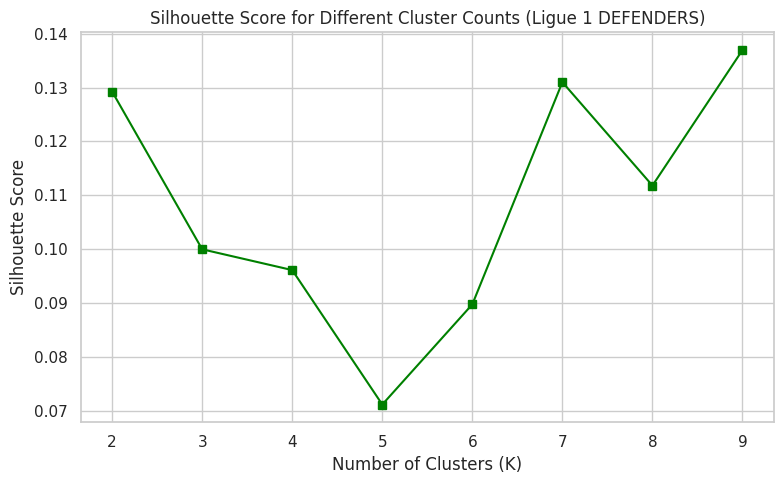

✅ Silhouette Score plot generated. Highest score suggests optimal separation between clusters.


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load PCA-transformed Ligue 1 dataset
try:
    df_pca = pd.read_csv("ligue1_defenders_2023_24_pca_transformed.csv")
    print("✅ PCA transformed data loaded successfully for Silhouette Score calculation.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_pca_transformed.csv' not found.")
    print("Please ensure this file has been generated by the PCA step.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# Select number of principal components for clustering
n_components_for_clustering = 20
if n_components_for_clustering > df_pca.shape[1]:
    print(f"⚠️ Requested {n_components_for_clustering} components, but only {df_pca.shape[1]} available.")
    n_components_for_clustering = df_pca.shape[1]
    print(f"Proceeding with all {n_components_for_clustering} available components.")

X_for_clustering = df_pca.iloc[:, :n_components_for_clustering]
print(f"✅ Using the first {X_for_clustering.shape[1]} principal components for Silhouette Score calculation.")

# Compute silhouette scores for K in range
silhouette_scores = []
K_range = range(2, 10)

print(f"🔢 Calculating Silhouette Scores for K from {min(K_range)} to {max(K_range)}...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_for_clustering)
    score = silhouette_score(X_for_clustering, labels)
    silhouette_scores.append(score)

print("✅ Silhouette Scores calculated across tested K values.")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='s', color='green')
plt.title("Silhouette Score for Different Cluster Counts (Ligue 1 DEFENDERS)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.xticks(K_range)
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Silhouette Score plot generated. Highest score suggests optimal separation between clusters.")


## Silhouette Score Interpretation:

The Silhouette Score measures how well-separated the clusters are. A higher score indicates better-defined and more distinct clusters.

Looking at the Silhouette Score plot:

*   Highest score: **k = 2 (≈ 0.24)**
*   Next best: **k = 3 (≈ 0.17)**
*   Noticeable drop: From k = 3 to k = 4 (≈ 0.15), and lower beyond.

**Interpretation:**

The Silhouette Score strongly favors **k=2** for best cluster separation, with **k=3** as the next best option. The relatively low scores overall suggest the defender clusters may not be extremely well-separated.

## Choosing the Optimal K: Elbow Method vs. Silhouette Score

Based on the analysis:

*   **Elbow Method:** Suggests an elbow around K=3 or K=4.
*   **Silhouette Score:** Highest at K=2 (≈ 0.24), next best at K=3 (≈ 0.17).

**Decision:**

Considering both, **K=3** is chosen as the most balanced option. It's supported by the Elbow method and has the second-highest Silhouette score, allowing for potentially more distinct tactical roles than K=2, while acknowledging some potential overlap compared to K=2.

#6. KMeans Training & Cluster visualization - LIGUE 1 DEFENDERS

✅ PCA transformed data loaded successfully for K-Means clustering.
✅ Preprocessed encoded team data loaded successfully for merging cluster labels.
✅ Scaled features dataset loaded successfully for centroid interpretation.
✅ Using first 20 PCA components for clustering.
✅ K-Means clustering performed with K=3.

 Cluster distribution (K=3):
Cluster
0    56
1    26
2    40

 Clustered defender data saved as: ligue1_defenders_2023_24_clustered.csv

 First 5 rows with cluster assignment:
                name  position  minutes  duels_total_api  duels_won_api  goals_total  shots_total  shots_on_target  dribbles_attempts  dribbles_success  touches_total  passes_total_api  passes_total_accuracy_api  tackles_api  interceptions_api  shots_on_target_perc  dribbles_success_perc             name_clean     team_clean      player_name_fbref nation_fbref  90s_played_fbref  passes_completed_total_fbref  passes_short_cmp_fbref  passes_short_att_fbref  passes_short_acc_fbref  passes_medium_cmp_fbref  pa

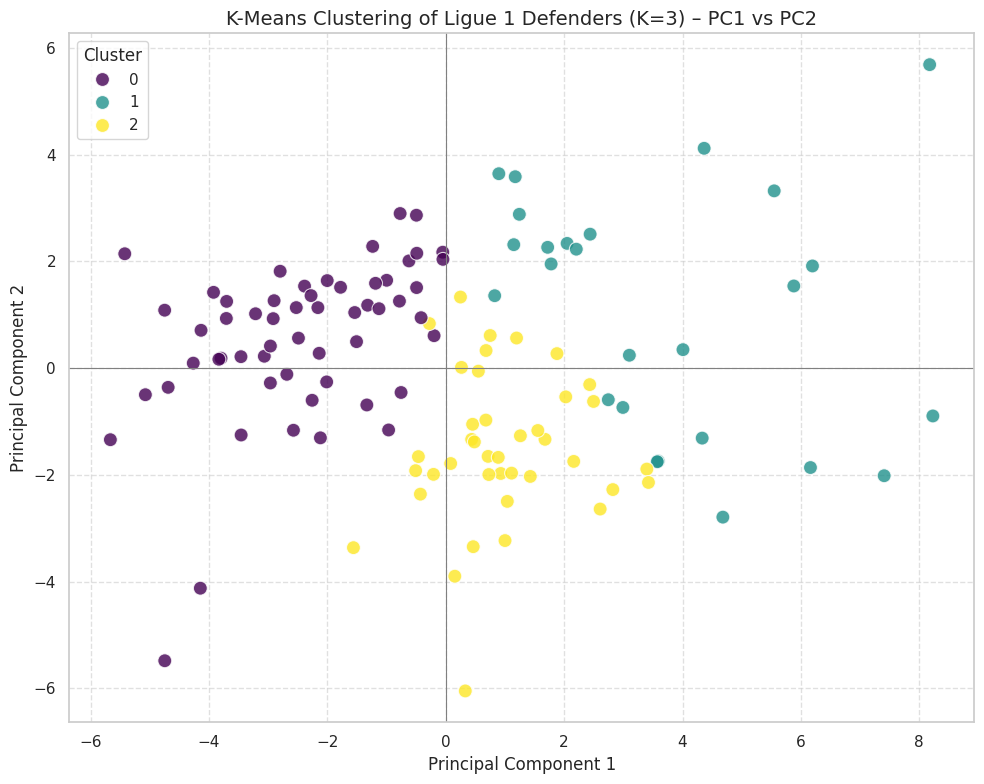

✅ Clustering visualization generated.

 Interpreting Cluster Archetypes via Scaled Feature Centroids...

 Scaled Feature Means by Cluster (transpose view):
Cluster                                      0         1         2
duels_total_p90                      -0.644577  0.941811  0.290232
duels_won_p90                        -0.501178  1.018088  0.039893
interceptions_p90                    -0.074204  0.689579 -0.344341
interceptions_p90_fbref              -0.041854  0.645024 -0.360670
tackles_p90                          -0.711206  1.290559  0.156825
tackles_p90_fbref                    -0.742556  1.320231  0.181428
tackles_won_p90_fbref                -0.708072  1.164269  0.234527
tackles_interceptions_p90_fbref      -0.595295  1.349767 -0.043936
blocks_p90_fbref                      0.130677  0.176658 -0.297776
shots_blocked_p90_fbref               0.642524 -0.299773 -0.704682
passes_blocked_p90_fbref             -0.553864  0.540639  0.423994
clearances_p90_fbref                  0.

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load PCA-transformed Ligue 1 data
try:
    df_pca = pd.read_csv("ligue1_defenders_2023_24_pca_transformed.csv")
    print("✅ PCA transformed data loaded successfully for K-Means clustering.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_pca_transformed.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# Load preprocessed data with encoded teams
try:
    df_defenders_preprocessed_encoded_team = pd.read_csv("ligue1_defenders_2023_24_preprocessed_encoded_team.csv")
    print("✅ Preprocessed encoded team data loaded successfully for merging cluster labels.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_preprocessed_encoded_team.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# Load scaled features
try:
    df_scaled_features = pd.read_csv("ligue1_defenders_2023_24_scaled_metrics.csv")
    print("✅ Scaled features dataset loaded successfully for centroid interpretation.")
except FileNotFoundError:
    print("❌ Error: 'ligue1_defenders_2023_24_scaled_metrics.csv' not found.")
    exit()
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    exit()

# Use first 20 principal components (or all available if <20)
n_components_for_clustering = 20
if n_components_for_clustering > df_pca.shape[1]:
    print(f"⚠️ Requested {n_components_for_clustering}, only {df_pca.shape[1]} available.")
    n_components_for_clustering = df_pca.shape[1]
X_for_clustering = df_pca.iloc[:, :n_components_for_clustering]
print(f"✅ Using first {X_for_clustering.shape[1]} PCA components for clustering.")

# Run K-Means clustering with K=3
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_for_clustering)
print(f"✅ K-Means clustering performed with K={n_clusters}.")

# Merge cluster labels with full feature set
df_defenders_final_with_clusters = df_defenders_preprocessed_encoded_team.copy()
df_defenders_final_with_clusters['Cluster'] = cluster_labels

# Display cluster distribution
print(f"\n Cluster distribution (K={n_clusters}):")
print(df_defenders_final_with_clusters['Cluster'].value_counts().sort_index().to_string())

# Save clustered dataset
output_filename = "ligue1_defenders_2023_24_clustered.csv"
df_defenders_final_with_clusters.to_csv(output_filename, index=False)
print(f"\n Clustered defender data saved as: {output_filename}")

# Preview
print("\n First 5 rows with cluster assignment:")
print(df_defenders_final_with_clusters.head().to_string())

# --- Visualization: Clusters on PC1 vs PC2 ---
print("\n Visualizing Clusters in PCA space...")
df_pca_with_clusters = df_pca.copy()
df_pca_with_clusters['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    data=df_pca_with_clusters,
    palette='viridis',
    s=100, alpha=0.8, edgecolor='w', legend='full'
)
plt.title(f'K-Means Clustering of Ligue 1 Defenders (K={n_clusters}) – PC1 vs PC2', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='grey', linewidth=0.8)
plt.axvline(0, color='grey', linewidth=0.8)
plt.tight_layout()
plt.show()
print("✅ Clustering visualization generated.")

# --- Cluster Interpretation ---
print("\n Interpreting Cluster Archetypes via Scaled Feature Centroids...")
df_scaled_features_with_clusters = df_scaled_features.copy()
df_scaled_features_with_clusters['Cluster'] = cluster_labels
cluster_centroids_scaled = df_scaled_features_with_clusters.groupby('Cluster').mean()

# Display cluster profiles
print("\n Scaled Feature Means by Cluster (transpose view):")
print(cluster_centroids_scaled.T.to_string())
print("\n Centroids displayed. Positive = above-average trait, Negative = below-average.")
print("Use this to define defender roles for each cluster.")


# Ligue 1 Defender Cluster Profiles (K=3)

Based on the analysis of scaled feature centroids, we've identified three distinct tactical profiles among Ligue 1 defenders:

# Cluster 0: The Positional Ball-Player

For Cluster 0, "The Positional Ball-Player," these defenders are generally below average in high-volume defensive actions like duels and tackles but show above-average passing accuracy, particularly in short and medium passes. They are above average in clearing the ball and blocking shots, suggesting a focus on positional defending and preventing immediate threats. They are less likely to be dribbled past. This profile aligns with more conservative, ball-playing defenders who prioritize distribution and defensive positioning over aggressive ball-winning.

# Cluster 1: The Aggressive Ball-Winner

Cluster 1, "The Aggressive Ball-Winner," includes defenders who are significantly above average in most defensive duels and tackling metrics, as well as interceptions. They are highly active in winning the ball back across the pitch. They are more likely to be dribbled past, likely due to their aggressive, front-foot style. Their passing accuracy is below average, and their attacking contribution is low. This profile represents defenders who are primarily focused on disruptive, high-volume defensive work.

# Cluster 2: The Offensive Wing-Back/Disrupter

Cluster 2, "The Offensive Wing-Back/Disrupter," presents a profile that is less defensively active in winning the ball back directly or clearing danger compared to the other clusters. They are below average in interceptions, shot blocks, and clearances, but are above average in blocking passes and have a higher attacking contribution (goals and assists). They are also dribbled past more often. This profile suggests a role that is more involved in offensive phases and disrupting passing lanes higher up the pitch, potentially representing offensive-minded full-backs or wing-backs.

These profiles offer a data-driven understanding of the diverse roles played by defenders in Ligue 1, moving beyond traditional positional labels.